#### By: Eriberto Lopez
* elopez3@uw.edu
* Klavins Lab - 07/16/19

In [1]:
# https://eyurtsev.github.io/FlowCytometryTools/tutorial.html

In [2]:
import sys
import re
import os
import urllib
from urllib.request import urlopen

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import norm

from FlowCytometryTools import *
from FlowCytometryTools.core.graph import plot_heat_map

from pylab import *

import pydent
from pydent import AqSession
from tqdm import tqdm


## Functions for Notebook
    * Execute blocks to gain notebook functionally and visualizations

In [3]:
# Will set the session to desired database
def session(database, aq_username, aq_password):
    if database == 'Production':
        server = "http://52.27.43.242/"
    elif database == 'Local':
        server = "http://localhost/"
    else:
        server = "http://52.27.43.242:81/"

    db = AqSession(aq_username, aq_password, server)
    return db


In [98]:
# The following functions are specifically for querying Aquarium and downloading flow cytometry data sets
# associated with the experimetal collections

def get_fc_upload_matrix(collection):
    for da in collection.data_associations:
        if 'SAMPLE_UPLOADs' in da.key:
            return da.object[da.key]['upload_matrix']
        
def download_flowCytometry_data_from_plans(plan_ids):
    data_dirs = []
    flatten = lambda l: [item for sublist in l for item in sublist]
    for pid in plan_ids:
        # Create plan_id folder
        cwd_path = os.getcwd()
        plan_dir_path = cwd_path + '/plan_{}'.format(pid)
        os.makedirs(plan_dir_path, exist_ok=True)
        plan = db.Plan.find(pid)
        for op in plan.operations:
            if op.operation_type.name == 'Flow Cytometry 96 well':
                plate = op.input('96 well plate').item
                if plate is not None:
                    # Create FC directory for each fc operation
                    flow_dir = plan_dir_path + '/op_{}_plate_{}'.format(op.id, plate.id)
                    os.makedirs(flow_dir, exist_ok=True)
                    uid_matrix = get_fc_upload_matrix(plate)
                    uids = list(filter(lambda x: x != -1, flatten(uid_matrix)))
                    uploads = db.Upload.find(uids)
                    for upload in uploads:
                        up_fname = "Well_" + upload.upload_file_name
                        upload.download(outdir=flow_dir, filename=up_fname)
                    print(f"Your flow cytometry data can be found in \n {flow_dir}")
                    data_dirs.append(flow_dir)
    return data_dirs
# FC Transformation Methods: https://www.ncbi.nlm.nih.gov/pubmed/15700280
def load_FCPlate(data_directories, transform_data=True, transformation_method = 'hlog'):
    # Other transformation_method is 'hlog'
    # Create a dict obj with the different plates coming from the directories created for each sync by od operation
    transformed_plate_dict = {}
    for datadir_path in data_directories:
        split_directories = datadir_path.split('/')
        datadir = split_directories[-2]+'_'+split_directories[-1]
        if os.path.isdir(datadir_path):
            raw_plate = FCPlate.from_dir(ID=datadir, path=datadir_path, parser='name') 
            if transform_data:
                # Transforming green and red channels
                log_plate = raw_plate.transform(transformation_method, b=50.0, channels=[u'FSC-A', u'SSC-A', u'FL1-A', u'FL2-A', u'FL3-A', u'FL4-A'])
                # plate = log_plate.dropna()
                transformed_plate_dict[datadir] = log_plate
                print(log_plate)
            else:
                transformed_plate_dict[datadir] = raw_plate
                print(raw_plate)
            
            print()
    return transformed_plate_dict

def get_culture_composition(part):
    culture_composition = {}
    for da in part.data_associations:
        culture_composition[da.key] = da.object[da.key]
    return culture_composition

def load_culture_compositions(db, transformed_plate_dict):
    # Gather a map of parts and their attributes in order to link the FC file to the culture condition
    culture_conditions_dict = {}
    for k, fc_data in transformed_plate_dict.items():
        collection = db.Collection.find(k.split('_')[-1])
        part_matrix = [[{}] * collection.object_type.columns for i in range(collection.object_type.rows)]
        for pa in db.PartAssociation.where({'part_id': [part.id for part in collection.parts]}):
            culture_composition = get_culture_composition(pa.part)
            culture_composition.update({'location':[pa.row, pa.column]})
            part_matrix[pa.row][pa.column] = culture_composition
        culture_conditions_dict[k]= part_matrix
    return culture_conditions_dict


### Functions for FlowCytometryTools library

In [5]:
def plot_gfp_controls(plate, gfp_range, save, save_path, wells_to_plot=['H09','H07']):
    channel = 'FL1-A'
    colors = ['green', 'grey']
    figure();
    plt.title('GFP Controls - {}'.format(plate.ID), fontsize='x-small');
    plt.xlim(gfp_range);
    plt.ylim(0, 1500);
    for i, well in enumerate(wells_to_plot):
        plate[well].plot(channel, bins=100, normed=False, alpha=0.9, gates=[on_threshold], color=colors[i]);
    if save.lower() == 'true':
        fig_name = 'GFP Controls - {}'.format(plate.ID)
        save_path = save_path + '/' + fig_name
        plt.savefig(save_path)
    
def plot_sytox_controls(plate, live_threshold, save, save_path, wells_to_plot=['H08','H07']):
    channel = 'FL4-A'
    colors = ['red', 'grey']
    figure();
    title('SYTOX Controls - {}'.format(plate.ID), fontsize='x-small')
    plt.xlim(sytox_range);
    plt.ylim(0, 2000);
    for i, well in enumerate(wells_to_plot):
        plate[well].plot(channel, bins=100, normed=False, alpha=0.9, gates=[live_threshold], color=colors[i])
    if save.lower() == 'true':
        fig_name = 'SYTOX Controls - {}'.format(plate.ID)
        save_path = save_path + '/' + fig_name
        plt.savefig(save_path)

def plot_plate_gfp(plate, gfp_range, on_threshold, save, save_path):
    channel = 'FL1-A'
    color = 'green'
    plt.figure(figsize=(20,10))

    xlim = gfp_range
    ylim = [0, 2000]

    # Title
    title('Green Flourescence Channel Data - {}'.format(plate.ID)) # , bbox={'facecolor': '0.8', 'pad': 50}

    # Plotting whole plate
    plate.plot(channel, bins=100, normed=False, color=color, 
               alpha=0.9, gates=[on_threshold],
               wspace=0.1, hspace=0.1, xlim=xlim, ylim=ylim);

    if save.lower() == 'true':
        fig_name = 'Green Flourescence Channel Data - {}'.format(plate.ID)
        save_path = save_path + '/' + fig_name
        plt.savefig(save_path)
        
        
        
def plot_plate_sytox(plate, sytox_range, live_threshold, save, save_path):
    channel = 'FL4-A'
    color = 'red'

    # Fig size
    plt.figure(figsize=(20,10))

    # Axis Formatting
    xlim = sytox_range
    ylim = [0,2000]

    # Title
    title('Red Flourescence Channel Data - {}'.format(plate.ID)) # , bbox={'facecolor': '0.8', 'pad': 50}

    # Plotting whole plate
    plate.plot(channel, bins=100, normed=False, color=color, 
               alpha=0.9,  gates=[live_threshold],
               wspace=0.1, hspace=0.1, xlim=xlim, ylim=ylim)

    if save.lower() == 'true':
        fig_name = 'Red Flourescence Channel Data - {}'.format(plate.ID)
        save_path = save_path + '/' + fig_name
        plt.savefig(save_path)
        
         
def plot_gfp_sytox(plate, live_off_poly, live_on_poly, dead_off_poly, save, save_path):
    channels_to_plot = ['FL1-A', 'FL4-A']

    plt.figure(figsize=(25,15))

    title('GFP vs SYTOX Red - {}'.format(plate.ID))

    plate.plot(
        channels_to_plot, bins=300, normed=False, 
        alpha=0.9, gates=[live_off_poly, live_on_poly, dead_off_poly],
        wspace=0.1, hspace=0.1, xlim=gfp_range, ylim=sytox_range
    )

    if save.lower() == 'true':
        fig_name = 'GFP vs SYTOX Red - {}'.format(plate.ID)
        save_path = save_path + '/' + fig_name
        plt.savefig(save_path)
         
def percentage_heatmaps(plate, on_off, live_dead):
    plt.figure(figsize=(20,10))
    if on_off.lower() == 'on':
        if live_dead.lower() == 'live':
            title('Percent of Cells in the ON-LIVE State - {}'.format(plate.ID))
            plot_heat_map(bins['live_on_pct'], show_colorbar=True, cmap=cm.Greens, vmin=0, vmax=100)
        else:
            title('Percent of Cells in the ON-DEAD State - {}'.format(plate.ID))
            plot_heat_map(bins['dead_on_pct'], show_colorbar=True, cmap=cm.Oranges, vmin=0, vmax=100)
    else:
        if live_dead.lower() == 'live':
            title('Percent of Cells in the OFF-LIVE State - {}'.format(plate.ID))
            plot_heat_map(bins['live_off_pct'], show_colorbar=True, cmap=cm.Blues, vmin=0, vmax=100)
        else:
            title('Percent of Cells in the OFF-DEAD State - {}'.format(plate.ID))
            plot_heat_map(bins['dead_off_pct'], show_colorbar=True, cmap=cm.Reds, vmin=0, vmax=100)

            
def make_poly_gate(vert, channels=['FL1-A','FL4-A']):
    poly = PolyGate(vert, channels)
    return poly

def live_dead_bar_percentage_plots(plate, live_off_poly, live_on_poly, dead_off_poly, save, save_path):
    # Creating percentage bar graph with on/off live/dead states for each dilution
    bin_keys = ('live_off_pct', 'live_on_pct', 'dead_off_pct', 'dead_on_pct')
    # Applying gates to plate
    bins = {
        'live_off_pct': get_pct_passing(plate.gate(live_off_poly)),
        'live_on_pct': get_pct_passing(plate.gate(live_on_poly)),
        'dead_off_pct': get_pct_passing(plate.gate(dead_off_poly))
    }
    bins['dead_on_pct'] = 100 - (bins['live_off_pct'] + bins['live_on_pct'] + bins['dead_off_pct'])
    
    # print(bins['dead_on_pct'])
    # print((bins['dead_on_pct'] + bins['live_off_pct'] + bins['live_on_pct'] + bins['dead_off_pct']))

    left = range(1,7)
    right = range(7,13)
    gate_strain = plate.ID.split('_')[2]
    
    layout_keys = ("WT", "{}_00".format(gate_strain), "{}_01".format(gate_strain), "{}_10".format(gate_strain), "{}_11".format(gate_strain))
    layout = {
        layout_keys[0]: [["A", left], ["C", right], ["F", left]],
        layout_keys[1]: [["A", right], ["D", left], ["F", right]],
        layout_keys[2]: [["B", left], ["D", right], ["G", left]],
        layout_keys[3]: [["B", right], ["E", left], ["G", right]],
        layout_keys[4]: [["C", left], ["E", right], ["H", left]]
    }

    plot_values = {k: {'mean': [], 'std': []} for k in bin_keys}
#     x_labels = []

    for k in bin_keys:
        for i, strain in enumerate(layout_keys):
            rows = layout[strain]
            for row in rows:
                let = row[0]
                values = []

                for num in row[1]:
                    values.append(bins[k].loc[let][num])

                plot_values[k]['mean'].append(np.mean(values))
                plot_values[k]['std'].append(np.std(values))

            if i < len(layout_keys) - 1:
                plot_values[k]['mean'].append(0)
                plot_values[k]['std'].append(0)
            
    font = {
        'family': 'normal',
        'weight': 'normal',
        'size': 18
    }
    plt.rc('font', **font)

    pal = sns.color_palette('muted')
    colors = pal[0:3] + [pal[4]]
    bin_labels = [to_label(k) for k in bin_keys]

    ind = range(len(plot_values['live_off_pct']['mean']))
    width = 0.8

    plts = []
    plt.figure(figsize=(20,10))

    bottom = [0] * len(ind)
    for i, key in enumerate(bin_keys):
        means = plot_values[key]['mean']
        p = plt.bar(ind, means, width, bottom=bottom, color=colors[i])
        plts.append(p)
        bottom = np.add(bottom, means)
    plt.title('{}'.format(plate.ID))
    plt.ylabel('Percentage of cells in each quadrant')

    xlabels = (['H', 'M', 'L', ''] * 5)[0:-1]
    plt.xticks(ind, xlabels)

    legend_colors = reversed([p[0] for p in plts])
    legend_labels = reversed(bin_labels)
    plt.legend(legend_colors, legend_labels, loc=(1.0, 0.7), fontsize='small', frameon=False, title='Quadrants')

    xpos = [1, 5, 9, 13, 17]

    for i, strain in enumerate(layout_keys):
        x = xpos[i]
        y = -9
        plt.text(x, y, strain, ha='center')
    
    if save.lower() == 'true':
        fig_name = '% ON_OFF LIVE_DEAD - {}.png'.format(plate.ID)
        save_path = save_path + '/' + fig_name
        plt.savefig(save_path)
    plt.show();
    
def get_pct_passing(gated_plate):
    return 100 * gated_plate.counts() / plate.counts()

def to_label(key):
    return ' '.join(key.split('_')[0:2]).upper()

In [10]:
def get_comparison(culture, component_type, attribute):
    if component_type in culture.keys():
        for sname, attributes in culture[component_type].items():
            return attributes[attribute]
    else:
        return 0
    
def groupby_component_attribute(condition_matrix, component_type, attribute):
    flatten = lambda l: [item for sublist in l for item in sublist]
    groupby_dict = {}
    for culture in flatten(condition_matrix):
        if component_type in culture.keys():
            for sname, attributes in culture[component_type].items():
                group_attr = attributes.get(attribute)
                if group_attr in groupby_dict.keys():
                    groupby_dict[group_attr].append(culture)
                else:
                    groupby_dict[group_attr] = [culture]
    return groupby_dict
        
def make_alphanumeric_map():
    rows = ['A','B','C','D','E','F','G','H']
    columns = ['01','02','03','04','05','06','07','08','09','10','11','12']
    alpha_numeric_map = []
    for row in rows:
        alpha_numeric_map.append(list(map(lambda x: row + x, columns)))
    return alpha_numeric_map

def format_well_coordinate(rc, well_map):
    r, c = rc
    return well_map[r][c]

## What Aquarium server do you want to connect to?
    Use the session function to create a session object and connect to Aquarium
    * Production
    * Nursery
    * Local
  

In [12]:
database = 'Production'
aq_username = ""
aq_password = ""

In [13]:
db = session(database, aq_username, aq_password)

## Use trident to download files that have been uploaded for a given plan
    * What plan(s) are your flow cytometry data in?
    * Enter the plan ids that you would like to analyze in a python list

In [14]:
plan_ids = [33599, 34206]

In [99]:
# Will create a directory on your local machine, containing your flow cytometry data
data_directories = download_flowCytometry_data_from_plans(plan_ids)
transformed_plate_dict = load_FCPlate(data_directories) 
culture_conditions_dict = load_culture_compositions(db, transformed_plate_dict)


/usr/local/lib/python3.7/site-packages/FlowCytometryTools/core/transforms.py:180: RuntimeWarning: divide by zero encountered in log10
  lxmin = max([log10(abs(xmin)), 0])


ID:
plan_33599_op_194641_plate_366960

Data:
    1    2    3    4    5    6    7    8    9    10   11   12
A  A01  A02  A03  A04  A05  A06  A07  A08  A09  A10  A11  A12
B  B01  B02  B03  B04  B05  B06  B07  B08                    
C  C01  C02  C03  C04  C05  C06                              
D                                                            
E                                                            
F                                                            
G                                                            
H                                                            

ID:
plan_34206_op_210010_plate_392983

Data:
    1    2    3    4    5    6    7    8    9    10   11   12
A  A01  A02  A03  A04  A05  A06  A07  A08  A09  A10  A11  A12
B  B01  B02  B03  B04  B05  B06  B07  B08  B09  B10          
C  C01  C02  C03  C04  C05  C06  C07                         
D  D01  D02  D03  D04  D05  D06  D07                         
E                                        

In [65]:
# Creating ThresholdGates
fl1_channel_line = 5450
fl1_threshold = ThresholdGate(fl1_channel_line, 'FL1-A', region='above')

fl4_channel_line = 4750
fl4_threshold = ThresholdGate(fl4_channel_line, 'FL4-A', region='above')

gfp_range = (3000, 8000)
gfp_interval = IntervalGate(gfp_range, 'FL1-A', region='in')


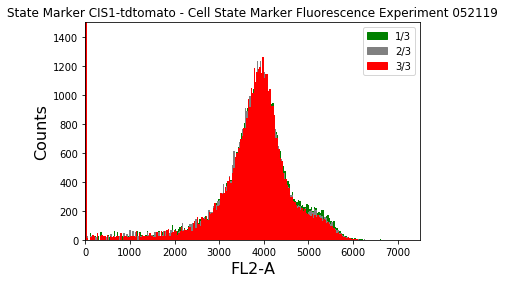

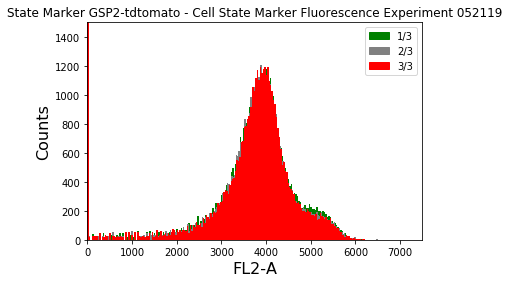

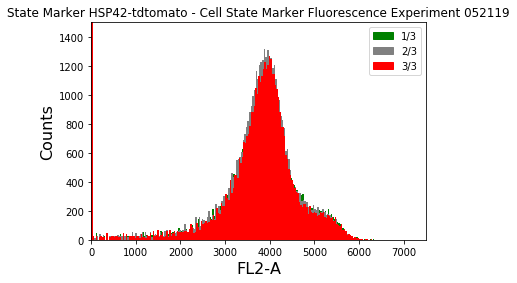

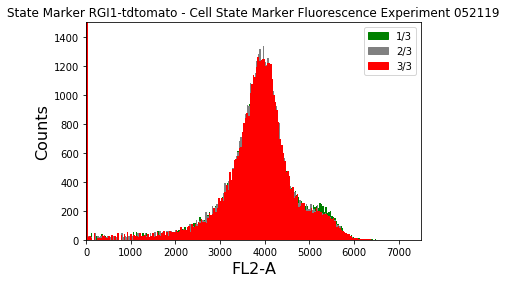

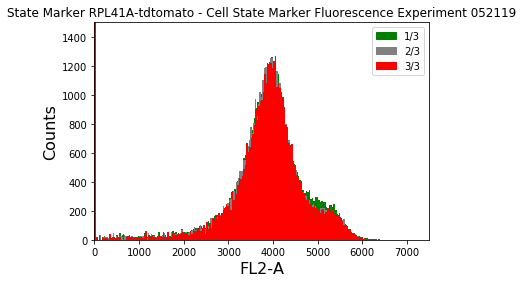

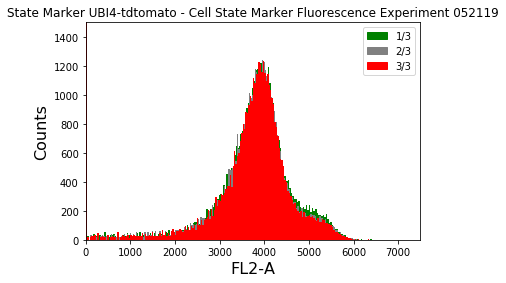

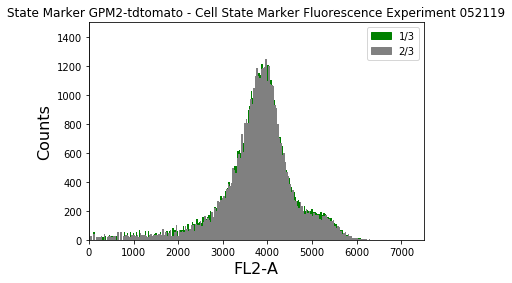

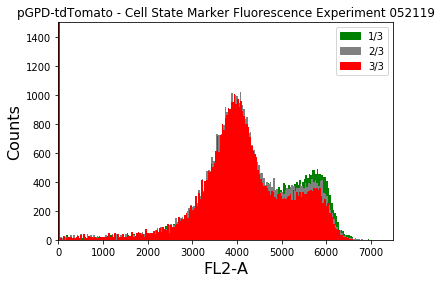

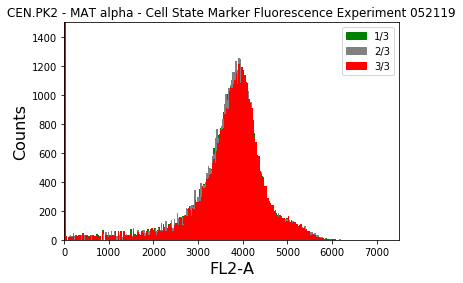

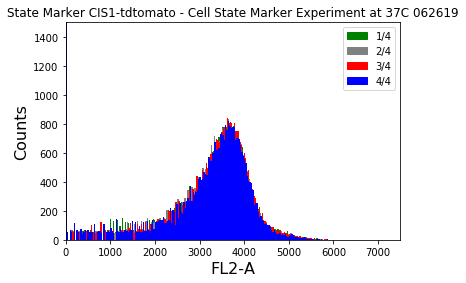

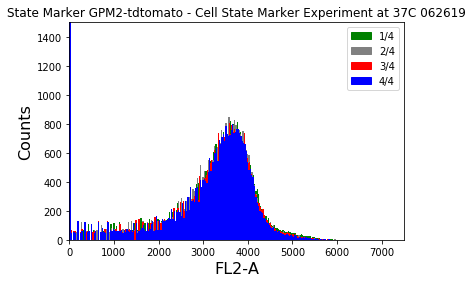

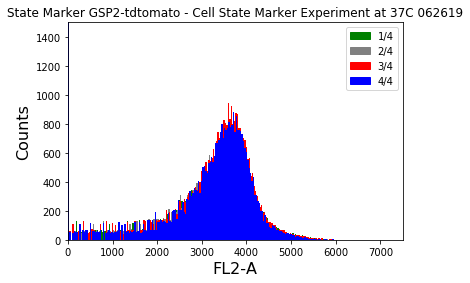

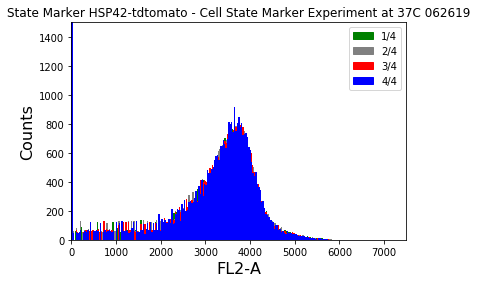

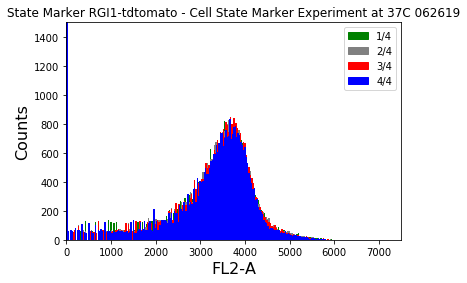

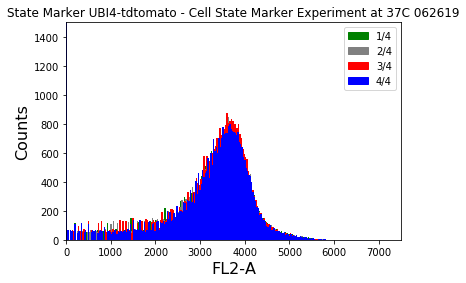

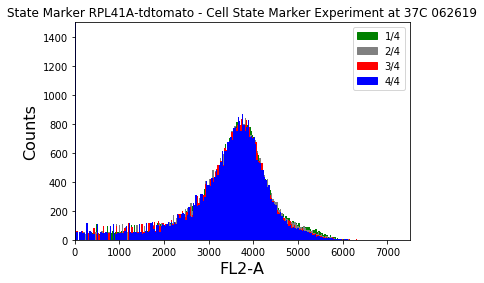

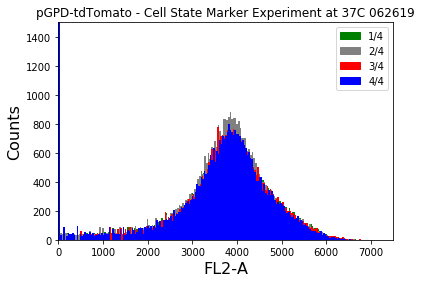

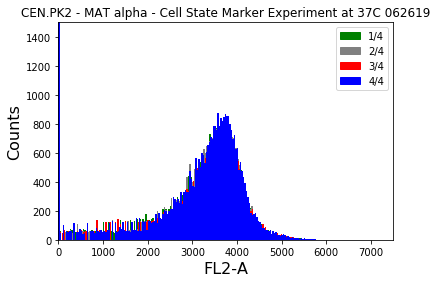

In [112]:
import matplotlib.patches as mpatches

channel = ['FL2-A']
colors = ['green', 'grey','red','blue']
well_map = make_alphanumeric_map()
for directory, condition_matrix in culture_conditions_dict.items():
#     print(directory)
    plan_name = db.Plan.find(directory.split('_')[1]).name
    groupby_dict = groupby_component_attribute(condition_matrix, component_type = 'Strain', attribute = 'item_id')
    fc_plate = transformed_plate_dict[directory]
    for group, culture_array in groupby_dict.items():
        label_array = [cult.get('Replicate') for cult in culture_array]
        component_item = db.Item.find(group)
        
        
        component_sample = component_item.sample.name
        plt.title(f'{component_sample} - {plan_name}'); plt.ylim(0, 1500); plt.xlim(0, 7500)
        handles = []
        for idx, culture in enumerate(culture_array):
            well = format_well_coordinate(culture.get('location'), well_map)
            handles.append(mpatches.Patch(color=colors[idx], label=label_array[idx]))
            fc_plate[well].plot(channel, color=colors[idx])
        plt.legend(handles=handles)
        plt.show()


/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


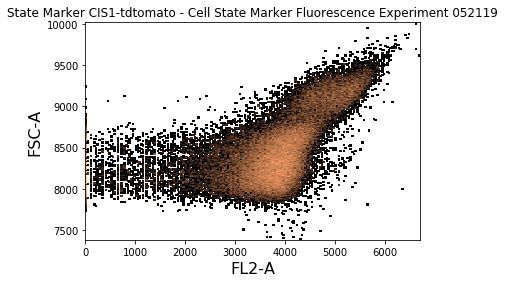

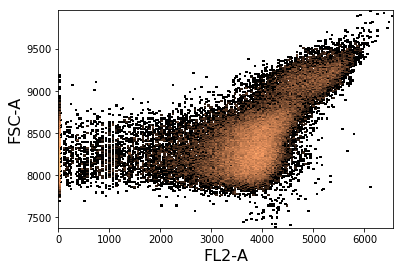

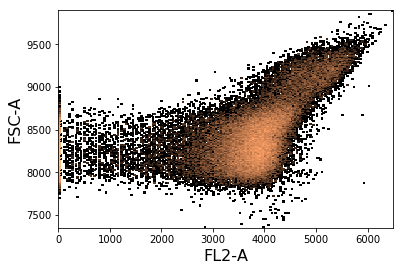

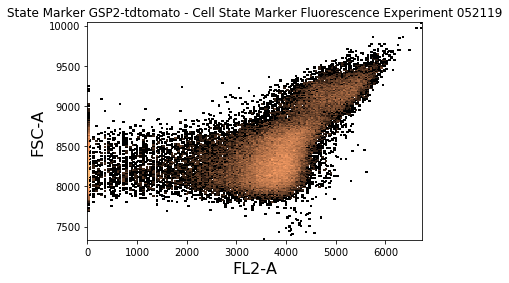

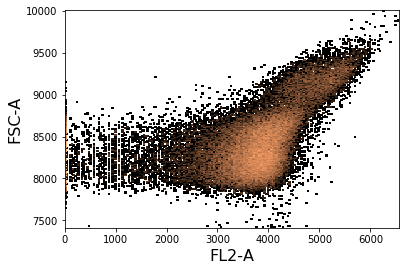

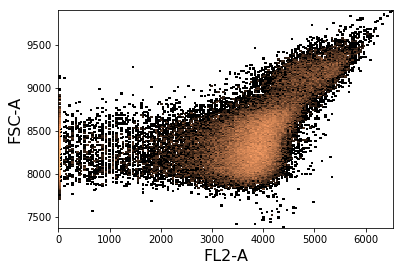

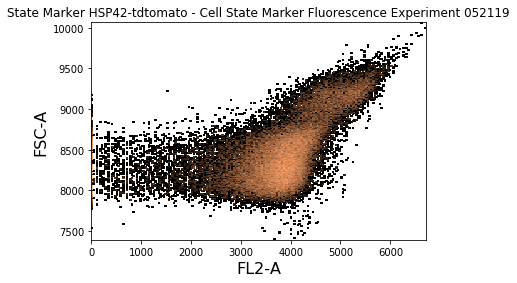

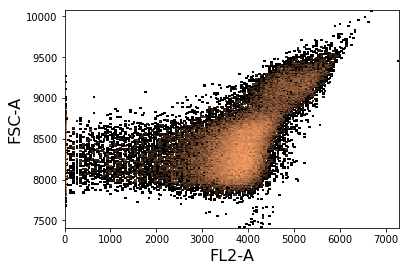

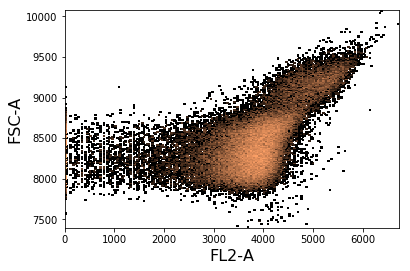

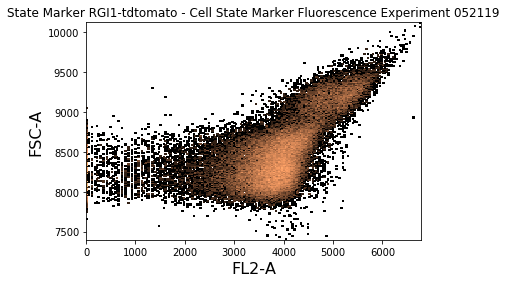

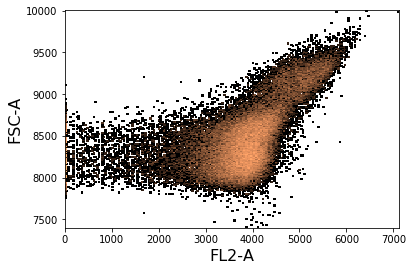

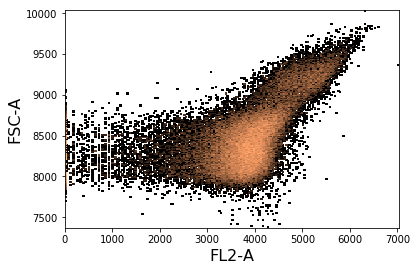

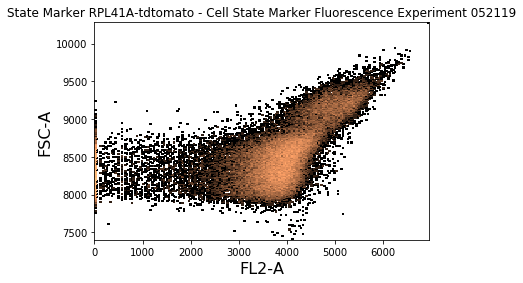

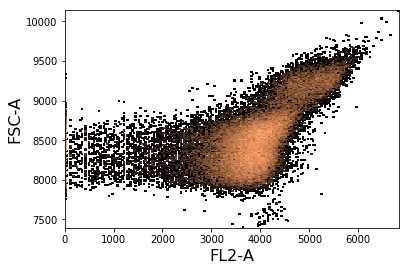

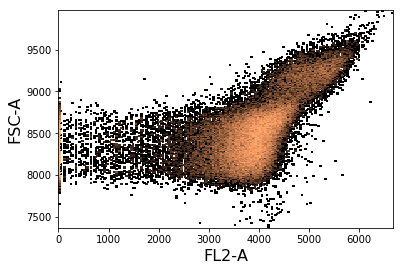

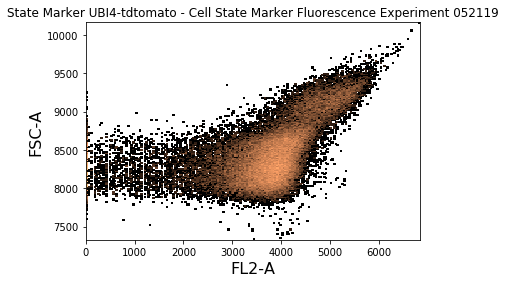

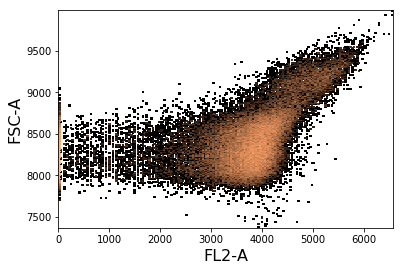

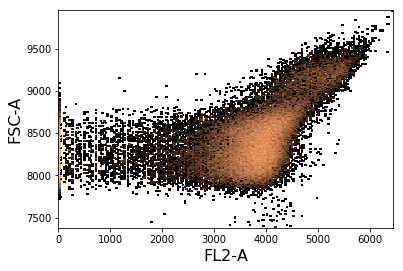

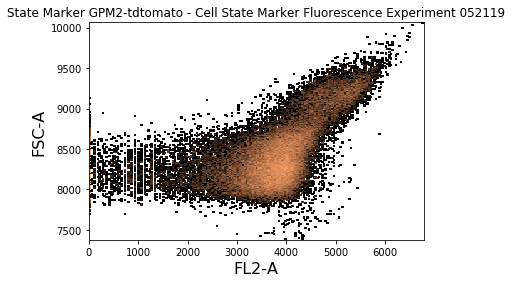

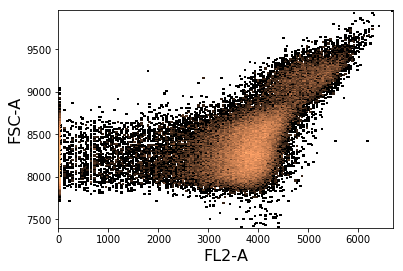

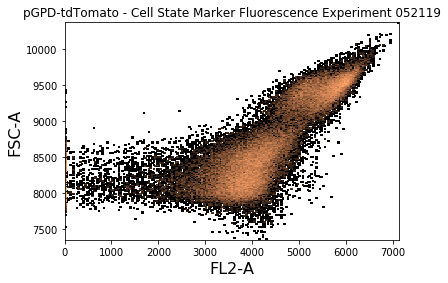

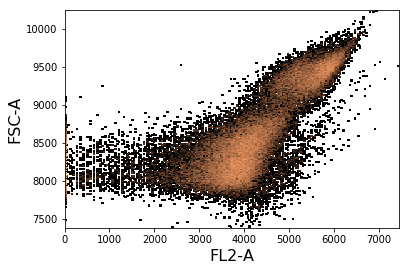

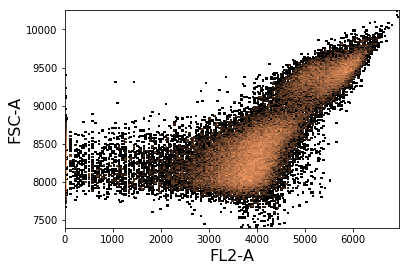

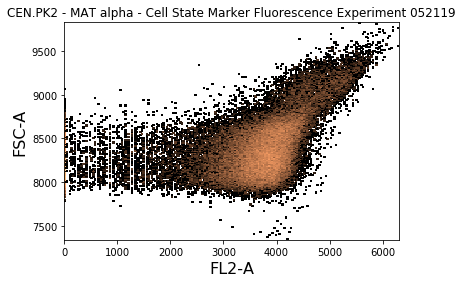

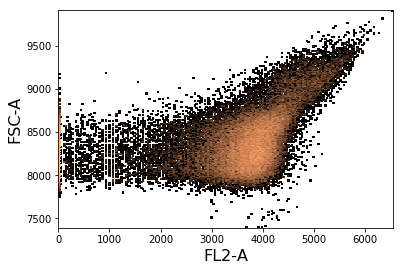

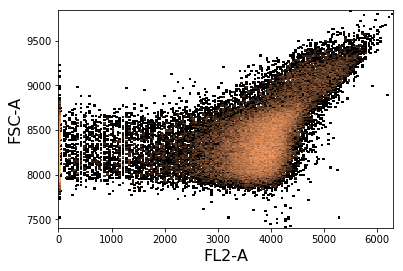

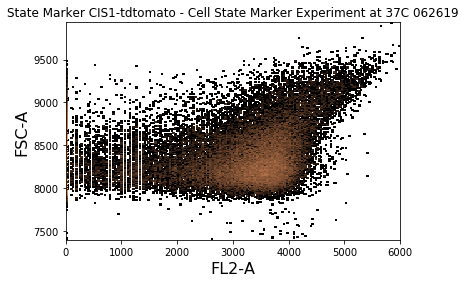

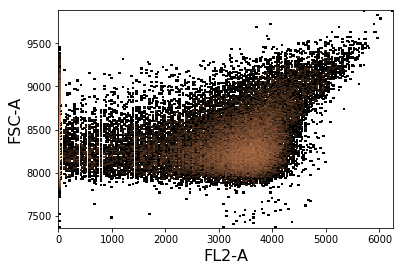

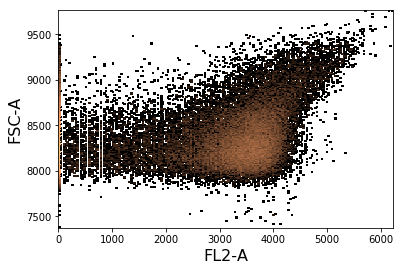

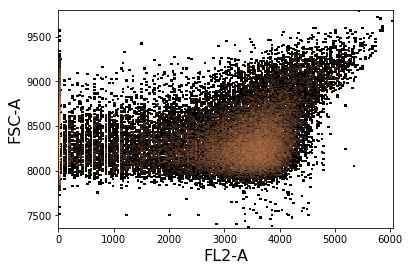

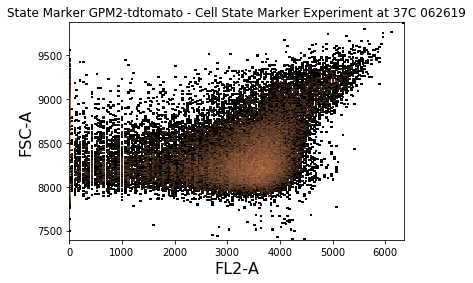

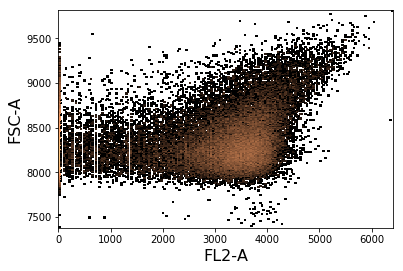

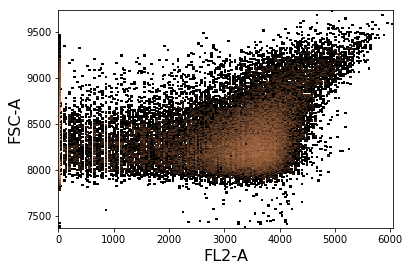

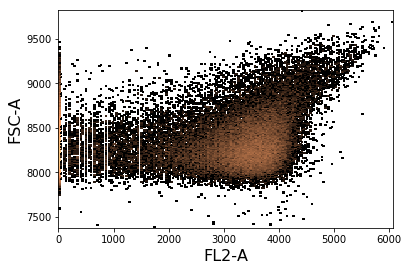

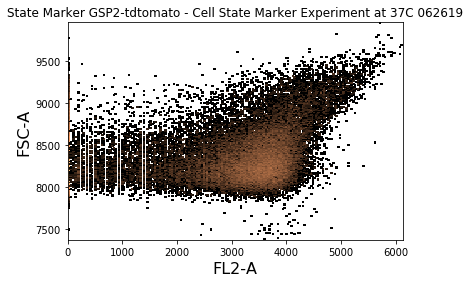

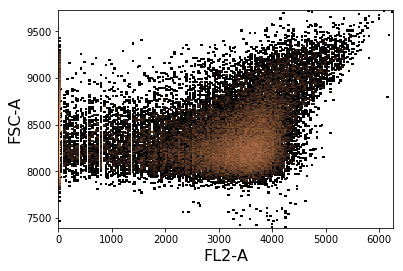

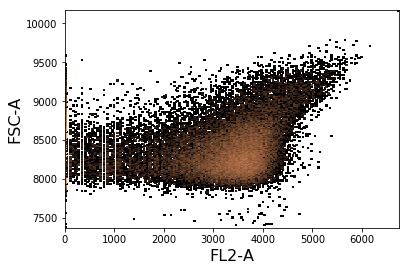

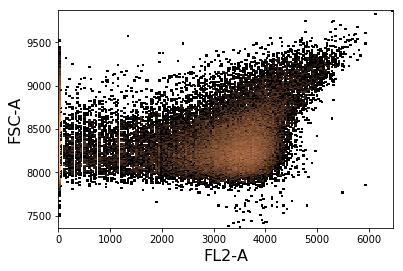

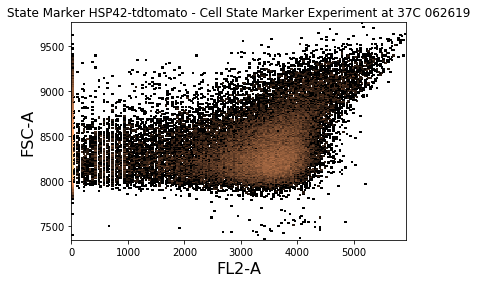

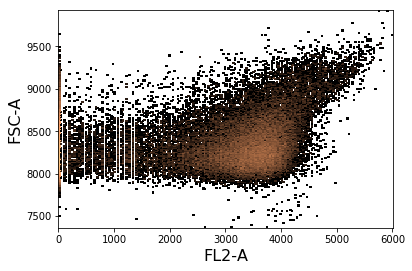

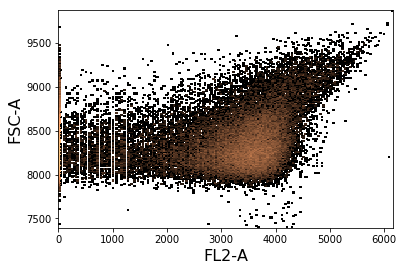

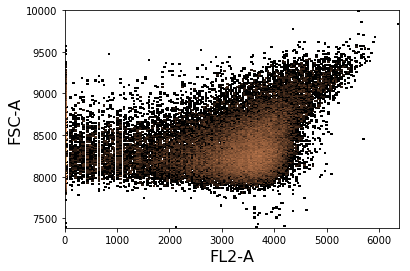

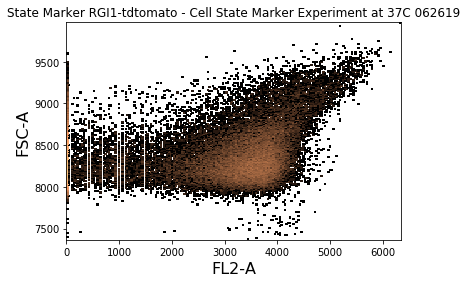

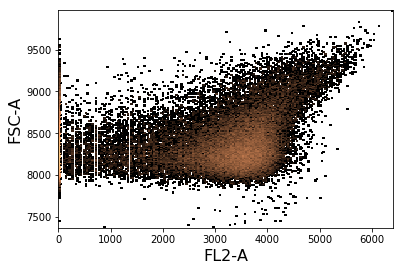

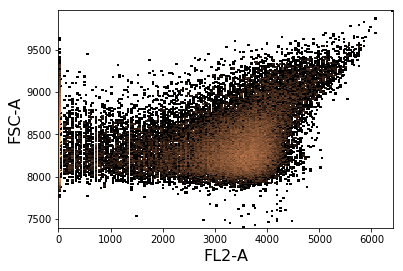

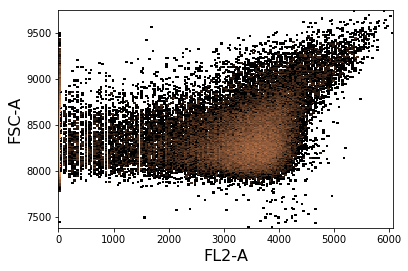

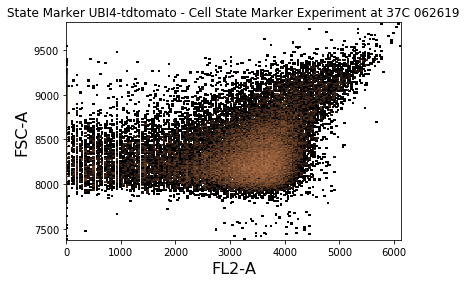

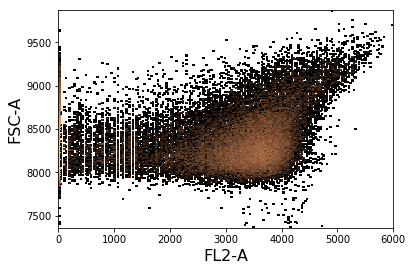

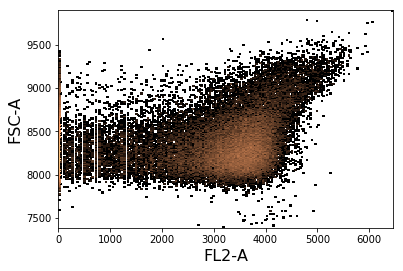

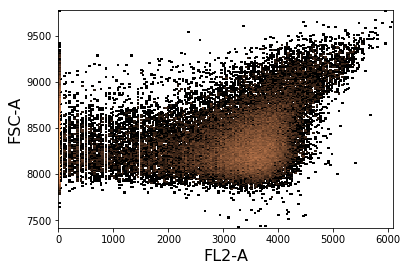

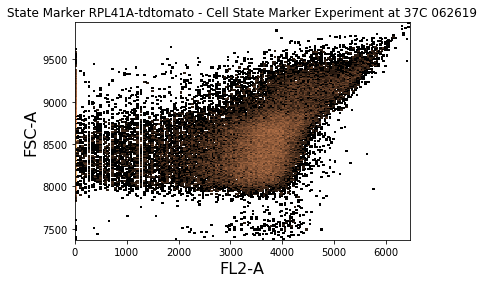

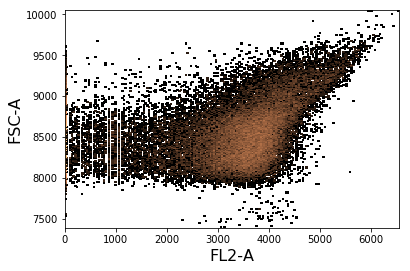

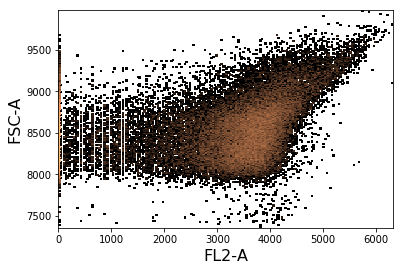

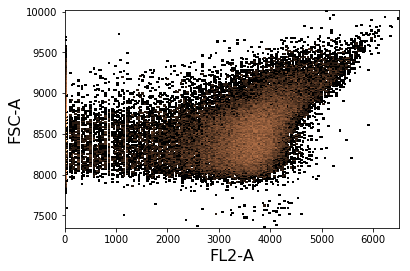

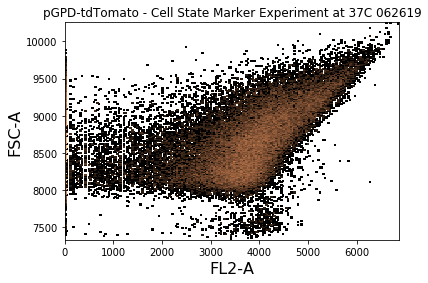

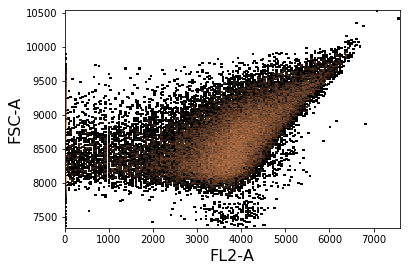

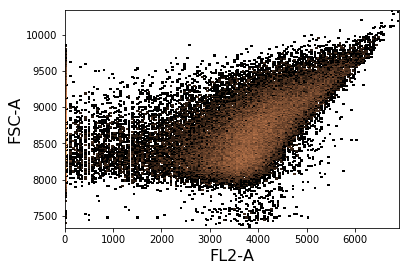

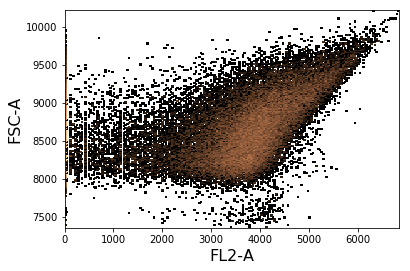

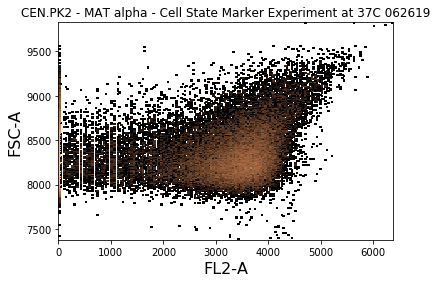

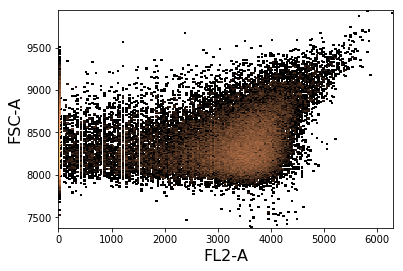

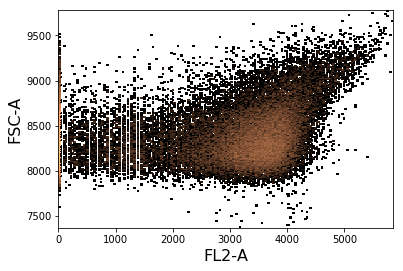

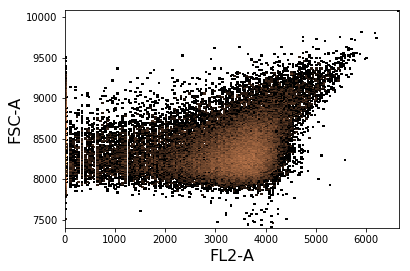

In [113]:
channel = ['FL2-A', 'FSC-A']
colors = ['green', 'grey','red','blue']
well_map = make_alphanumeric_map()
for directory, condition_matrix in culture_conditions_dict.items():
#     print(directory)
    plan_name = db.Plan.find(directory.split('_')[1]).name
    groupby_dict = groupby_component_attribute(condition_matrix, component_type = 'Strain', attribute = 'item_id')
    fc_plate = transformed_plate_dict[directory]
    for group, culture_array in groupby_dict.items():
        label_array = [cult.get('Replicate') for cult in culture_array]
        component_item = db.Item.find(group)
        
        
        component_sample = component_item.sample.name
        plt.title(f'{component_sample} - {plan_name}'); plt.ylim(0, 1500); plt.xlim(1000, 7500)
        handles = []
        for idx, culture in enumerate(culture_array):
            well = format_well_coordinate(culture.get('location'), well_map)
            handles.append(mpatches.Patch(color=colors[idx], label=label_array[idx]))
            fc_plate[well].plot(channel) #, color=colors[idx], gates=[fl1_threshold])
            plt.show()
#         plt.legend(handles=handles)
#         plt.show()


# Warning past this code block function!
# The following code requires further developement to function properly with High Throughput Culturing part associations that represent microbial cultures under experimental conditions.

### General threshold gates for GFP and SYTOX 
    * Use the following gates to analyze plates then, go back and tweek threshold gates to better select state pops.

In [109]:
# Creating ThresholdGates
on_off_cutoff = 5450
on_threshold = ThresholdGate(on_off_cutoff, 'FL1-A', region='above')

live_dead_cutoff = 4750
live_threshold = ThresholdGate(live_dead_cutoff, 'FL4-A', region='below')

gfp_range = (3000, 8000)
gfp_interval = IntervalGate(gfp_range, 'FL1-A', region='in')

sytox_range = (1000, 8000)
sytox_interval = IntervalGate(sytox_range, 'FL4-A', region='in')
vert = [
    (gfp_range[0], sytox_range[0]), 
    (on_off_cutoff, sytox_range[0]), 
    (on_off_cutoff, live_dead_cutoff), 
    (gfp_range[0], live_dead_cutoff)
]

live_off_poly = make_poly_gate(vert, channels=['FL1-A','FL4-A'])
# live_off_poly
vert = [
    (on_off_cutoff, sytox_range[0]), 
    (gfp_range[1], sytox_range[0]), 
    (gfp_range[1], live_dead_cutoff), 
    (on_off_cutoff, live_dead_cutoff)
]

live_on_poly = make_poly_gate(vert)

x1 = 4500
x2 = 7000

vert = [
    (gfp_range[0], live_dead_cutoff), 
    (x1, live_dead_cutoff), 
    (x2, sytox_range[1]), 
    (gfp_range[0], sytox_range[1])
]
dead_off_poly = make_poly_gate(vert)

In [ ]:
# I would like to display the whole plate but also provide a function/class that will be able to look up a 
# given well and label the histo with the culture conditions

# Also I would like a way to look at the cult conditions and select which wells to display based on the conditions 
# desired

# Would also like to keep the bar graph style of representing the population data

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/p

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


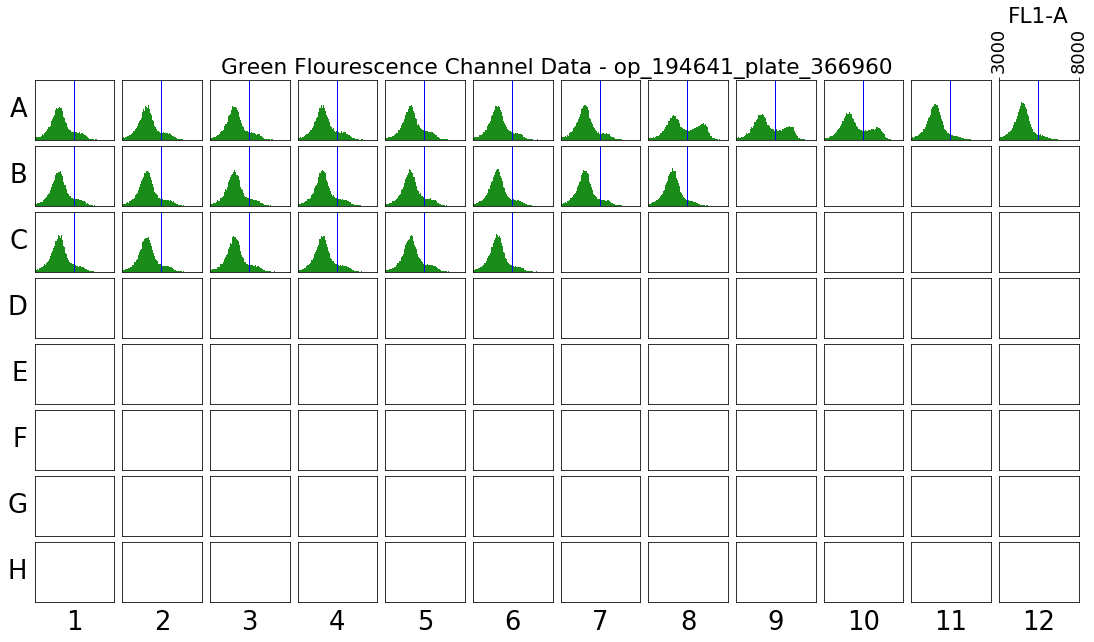

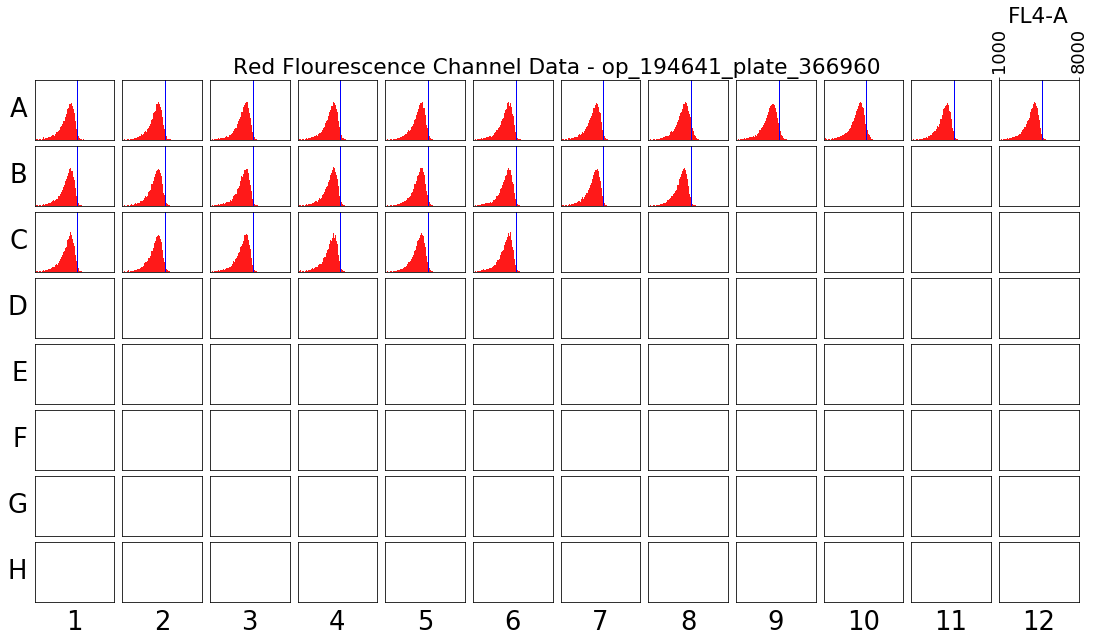

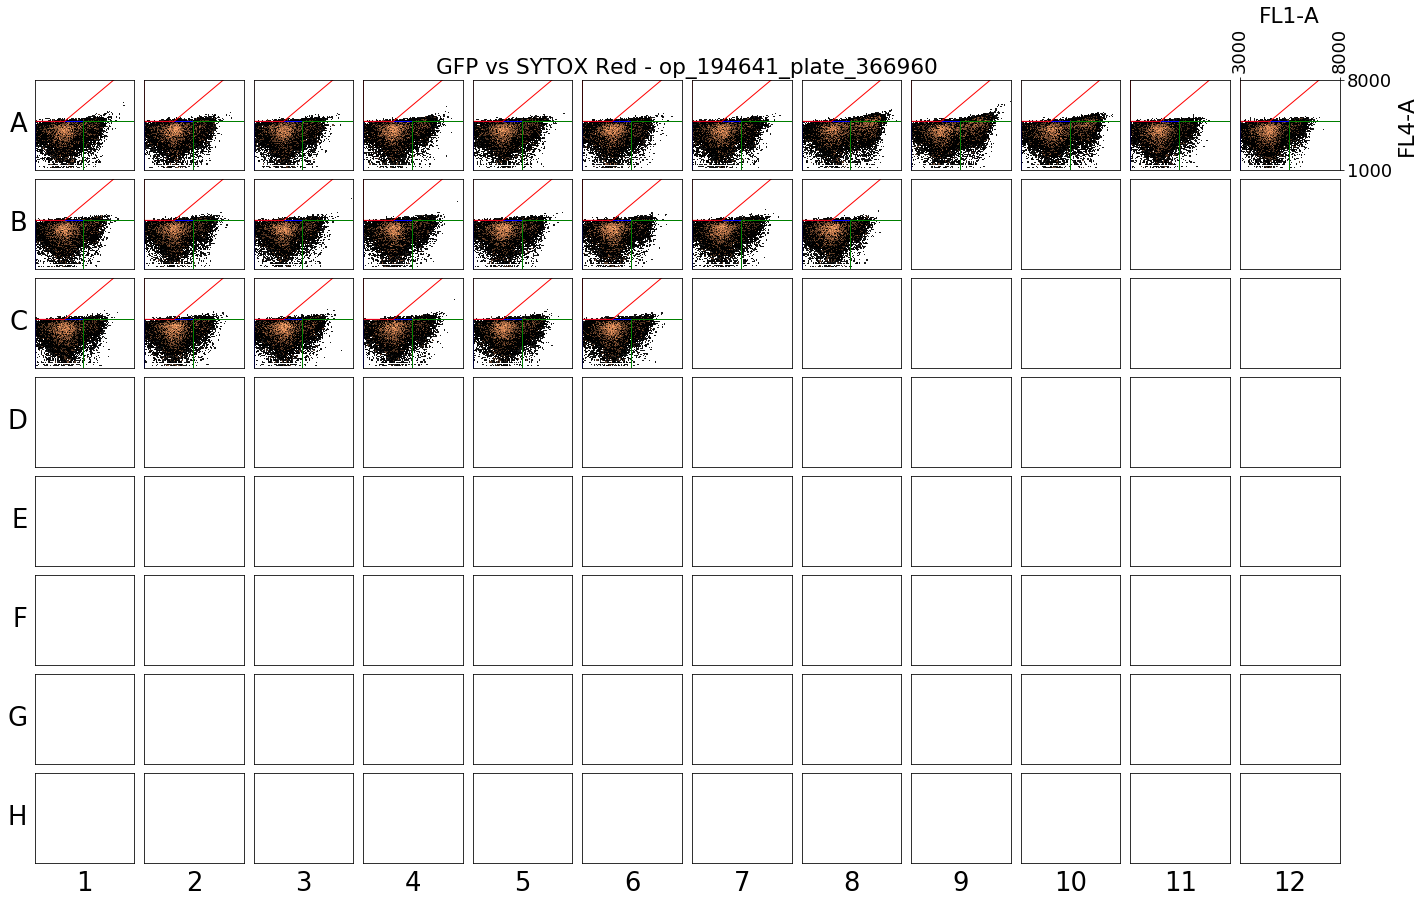

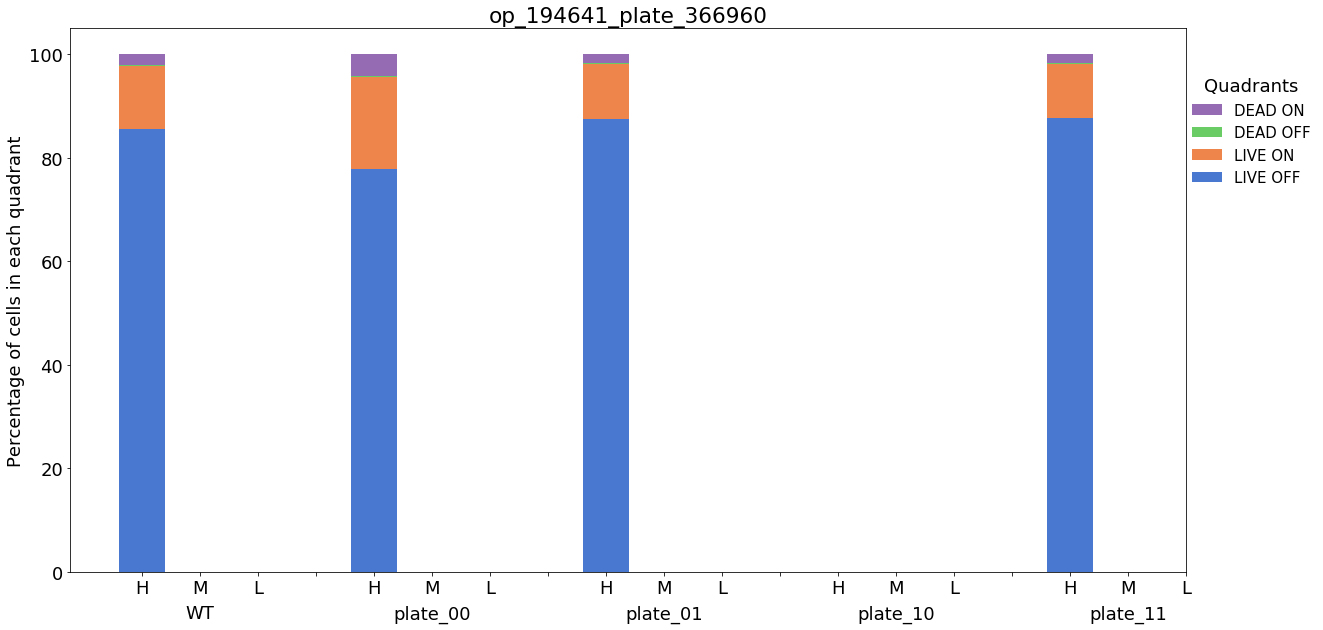

In [115]:
savefig = 'False'
for condition, plate in transformed_plate_dict.items():
#     save_path = os.getcwd() + '/plan_{}/{}'.format(plan_id, plate.ID)
    plate = plate.gate(gfp_interval).gate(sytox_interval)
    
    # Plotting 96 well GFP
    plot_plate_gfp(plate, gfp_range, on_threshold, savefig, save_path)

#     # Plotting 96 well red flourescence channel
    plot_plate_sytox(plate, sytox_range, live_threshold, savefig, save_path)

#     # 2-D Plotting GFP v SYTOX
    plot_gfp_sytox(plate, live_off_poly, live_on_poly, dead_off_poly, savefig, save_path)

    # percentage_heatmaps(plate, on_off='ON', live_dead='LIVE')

    # Applying gates to plate
    live_dead_bar_percentage_plots(plate, live_off_poly, live_on_poly, dead_off_poly, savefig, save_path)

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/p

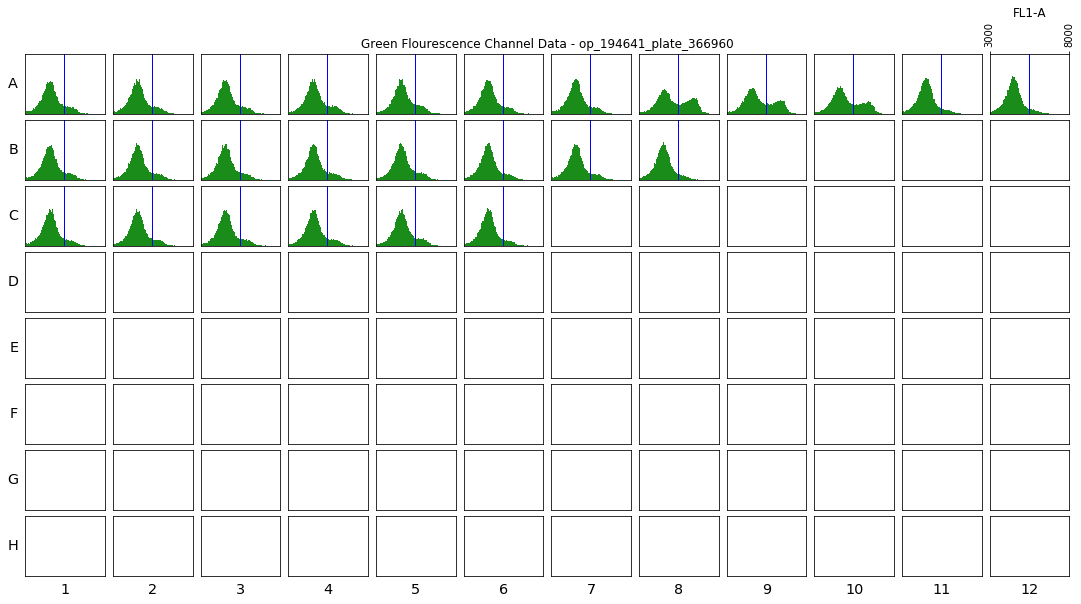

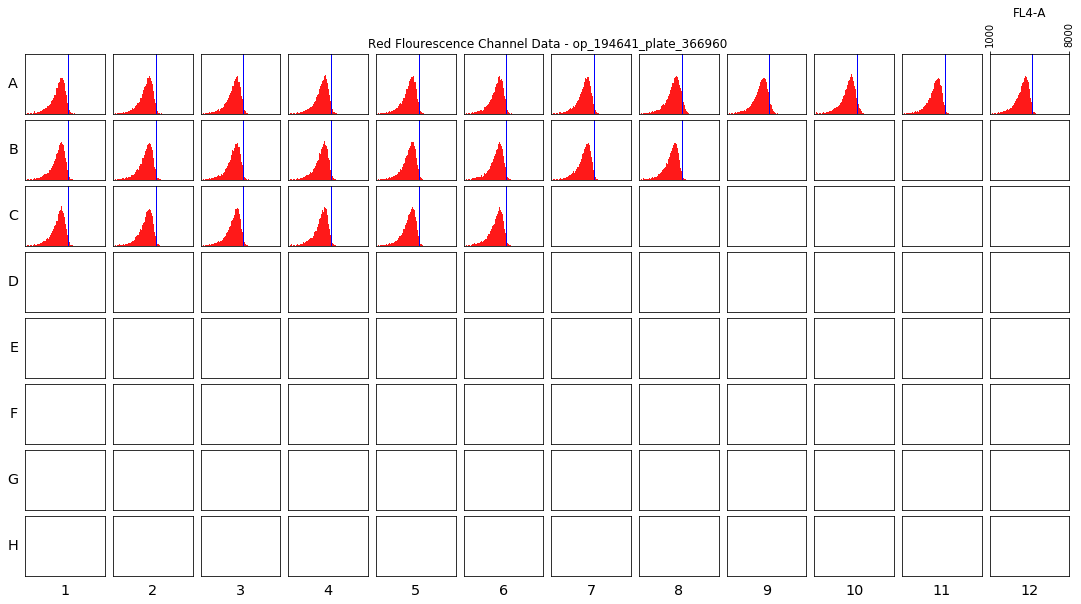

/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


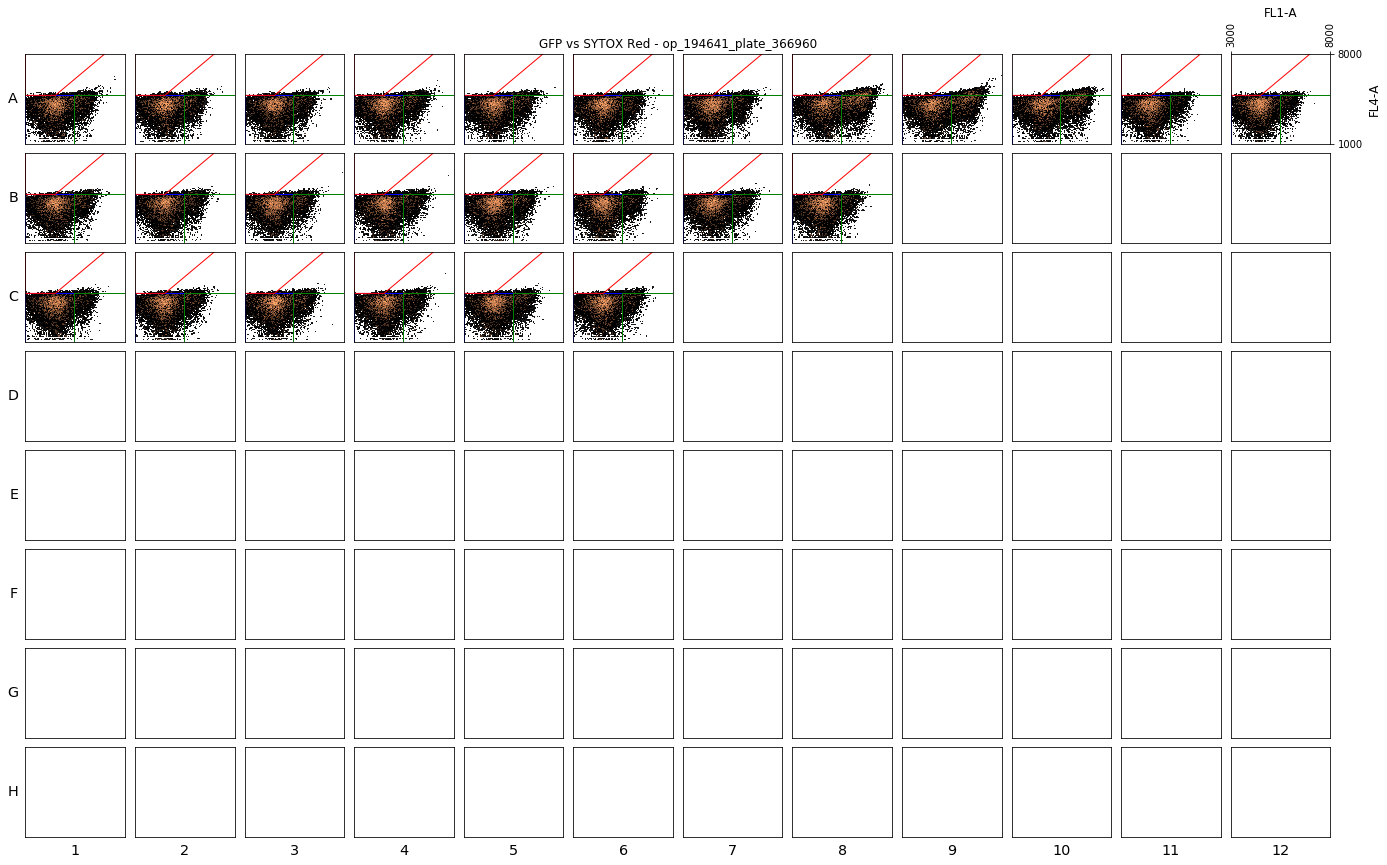

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


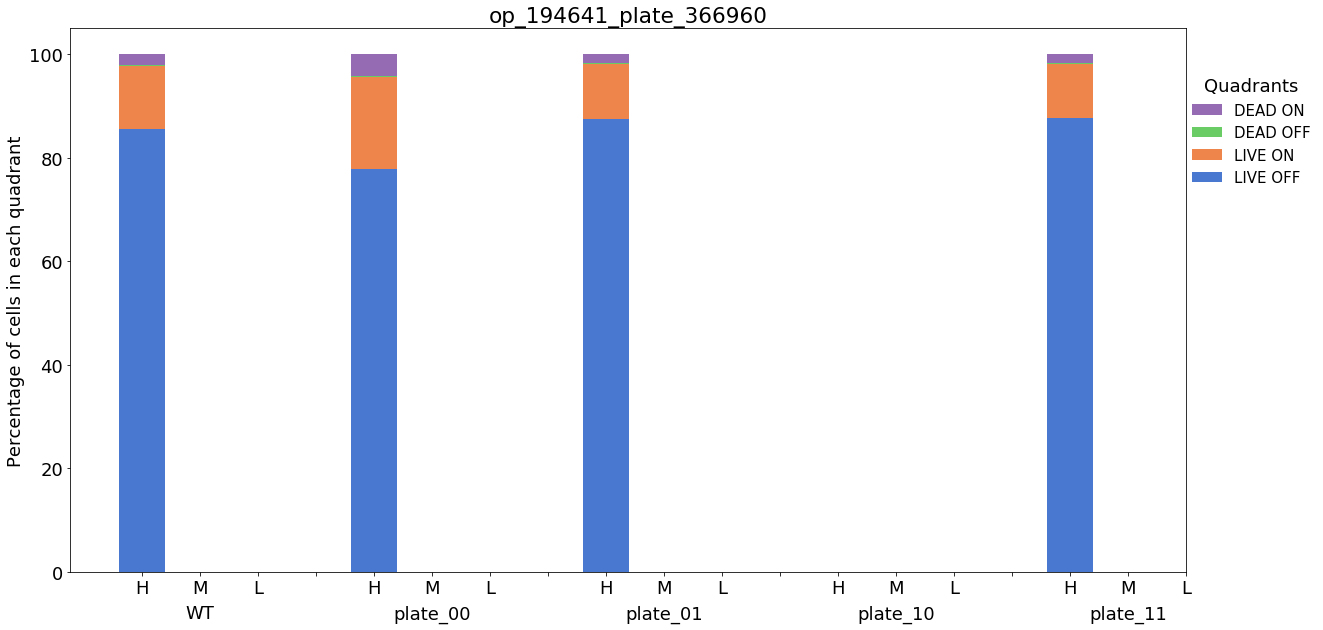

In [110]:
savefig = 'False'
for condition, plate in transformed_plate_dict.items():
    save_path = os.getcwd() + '/plan_{}/{}'.format(plan_id, plate.ID)
    plate = plate.gate(gfp_interval).gate(sytox_interval)
    
    # Plotting 96 well GFP
    plot_plate_gfp(plate, gfp_range, on_threshold, savefig, save_path)

    # Plotting 96 well red flourescence channel
    plot_plate_sytox(plate, sytox_range, live_threshold, savefig, save_path)

    # 2-D Plotting GFP v SYTOX
    plot_gfp_sytox(plate, live_off_poly, live_on_poly, dead_off_poly, savefig, save_path)

    # percentage_heatmaps(plate, on_off='ON', live_dead='LIVE')

    # Applying gates to plate
    live_dead_bar_percentage_plots(plate, live_off_poly, live_on_poly, dead_off_poly, savefig, save_path)

### After initial look at the data, look at plates individually and optimize threshold gates

In [35]:
transformed_plate_dict

{'YG_Hm_XOR_SC_Sorbitol_145346': <FCOrderedCollection 'YG_Hm_XOR_SC_Sorbitol_145346'>,
 'YG_Hm_XOR_Synthetic_Complete_145345': <FCOrderedCollection 'YG_Hm_XOR_Synthetic_Complete_145345'>,
 'YG_Hm_XOR_YPAD_145347': <FCOrderedCollection 'YG_Hm_XOR_YPAD_145347'>}

### Synthetic Complete Condition

In [36]:
# Creating ThresholdGates
on_off_cutoff = 5400
on_threshold = ThresholdGate(on_off_cutoff, 'FL1-A', region='above')

live_dead_cutoff = 5500
live_threshold = ThresholdGate(live_dead_cutoff, 'FL4-A', region='below')

gfp_range = (3000, 8000)
gfp_interval = IntervalGate(gfp_range, 'FL1-A', region='in')

sytox_range = (1000, 8000)
sytox_interval = IntervalGate(sytox_range, 'FL4-A', region='in')

vert = [
    (gfp_range[0], sytox_range[0]), 
    (on_off_cutoff, sytox_range[0]), 
    (on_off_cutoff, live_dead_cutoff), 
    (gfp_range[0], live_dead_cutoff)
]
live_off_poly = make_poly_gate(vert, channels=['FL1-A','FL4-A'])

vert = [
    (on_off_cutoff, sytox_range[0]), 
    (gfp_range[1], sytox_range[0]), 
    (gfp_range[1], live_dead_cutoff), 
    (on_off_cutoff, live_dead_cutoff)
]
live_on_poly = make_poly_gate(vert)

x1 = 4500
x2 = 7000
vert = [
    (gfp_range[0], live_dead_cutoff), 
    (x1, live_dead_cutoff), 
    (x2, sytox_range[1]), 
    (gfp_range[0], sytox_range[1])
]
dead_off_poly = make_poly_gate(vert)

#### Choosing the plate with the synthetic complete media condition & whether to save figures 

In [37]:
# savefig = 'True'
# save_path = os.getcwd() + '/plan_{}/{}'.format(plan_id, plate.ID)
# media = 'Synthetic_Complete'
# plate = ''
# for condition in transformed_plate_dict.items():
#     print(condition)
#     if media in condition[0]:
#         print(save_path)
#     if media in condition[0]:
#         plate = transformed_plate_dict[condition[0]]
# plate = plate.gate(gfp_interval).gate(sytox_interval)


media = 'Synthetic_Complete'
plate = ''
for condition in transformed_plate_dict.items():
    if media in condition[0]:
        plate = transformed_plate_dict[condition[0]]
plate = plate.gate(gfp_interval).gate(sytox_interval)
savefig = 'True'
save_path = os.getcwd() + '/plan_{}/{}'.format(plan_id, plate.ID)

print(save_path)


/Users/eribertolopez/Desktop/Aquarium_Programming/trident-master_v2/plan_18598/YG_Hm_XOR_Synthetic_Complete_145345


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


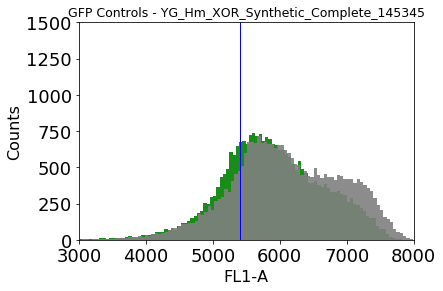

In [38]:
# Plotting gfp positive control
plot_gfp_controls(plate, gfp_range, savefig, save_path, wells_to_plot=['A07', 'A01'])

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


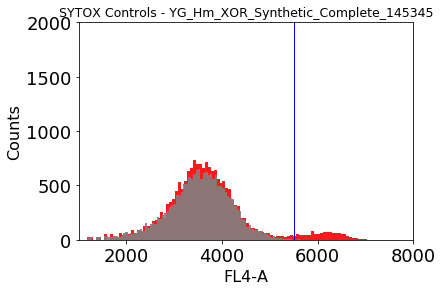

In [39]:
# Plotting SYTOX positive control
plot_sytox_controls(plate, live_threshold, savefig, save_path, wells_to_plot=['H08', 'H09'])

/Users/eribertolopez/Desktop/Aquarium_Programming/trident-master_v2/plan_18598/YG_Hm_XOR_Synthetic_Complete_145345


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


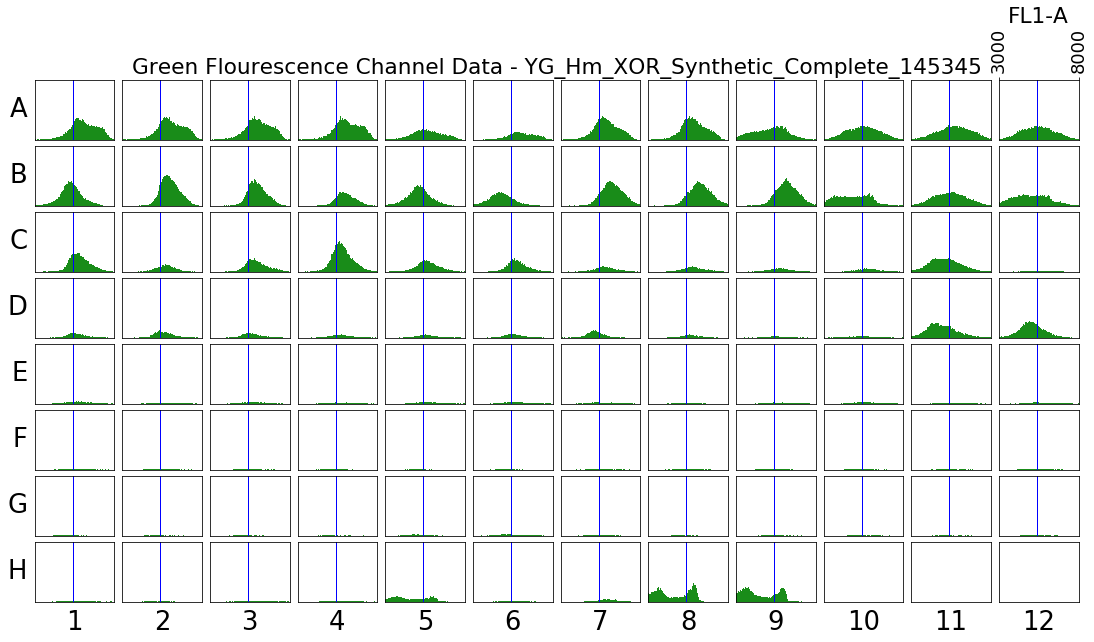

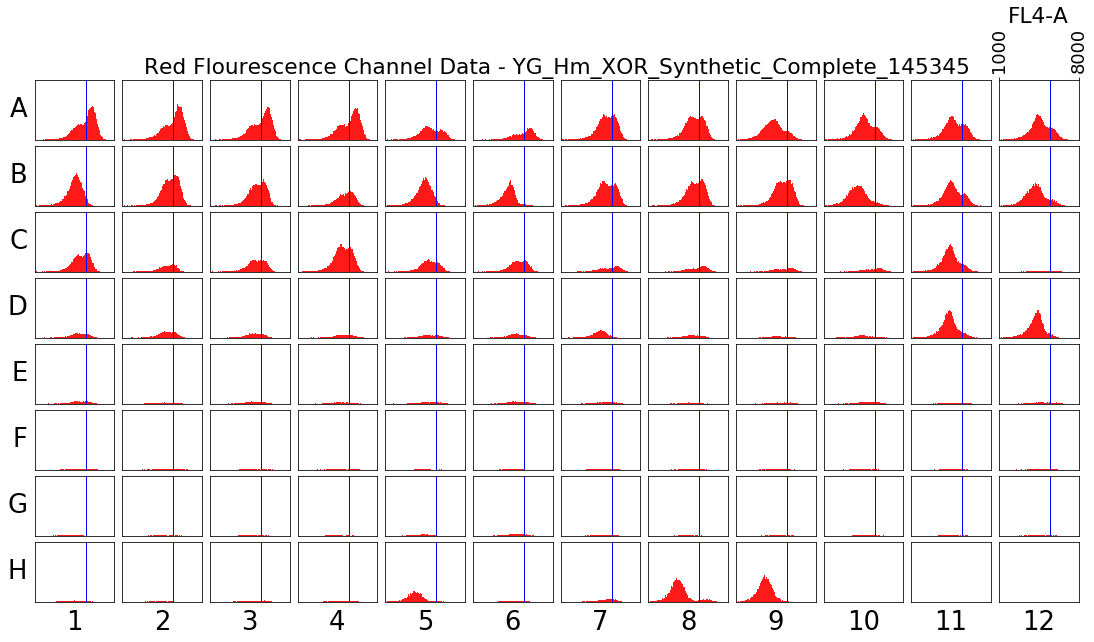

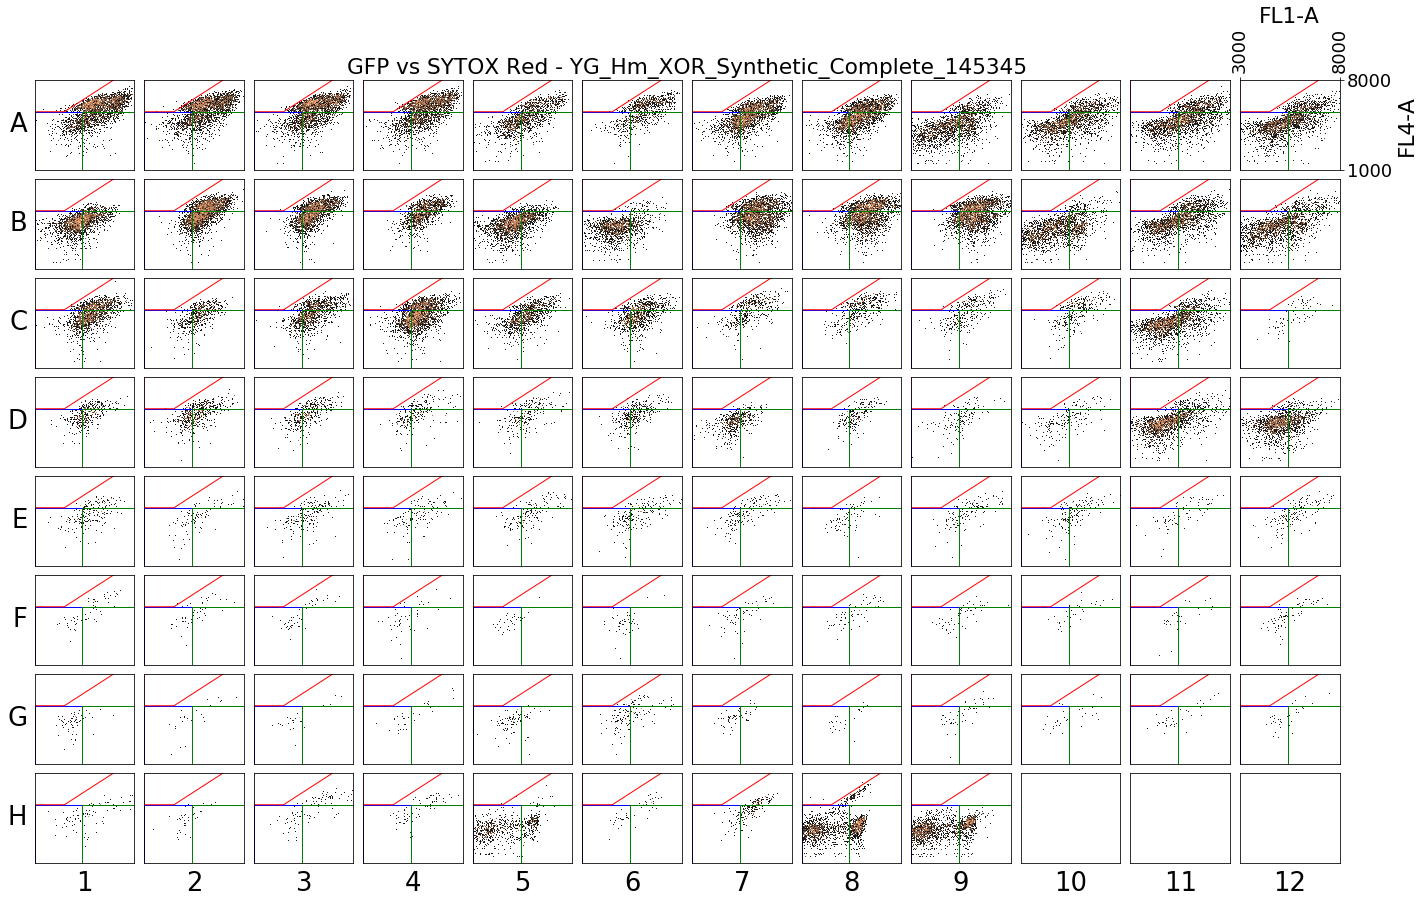

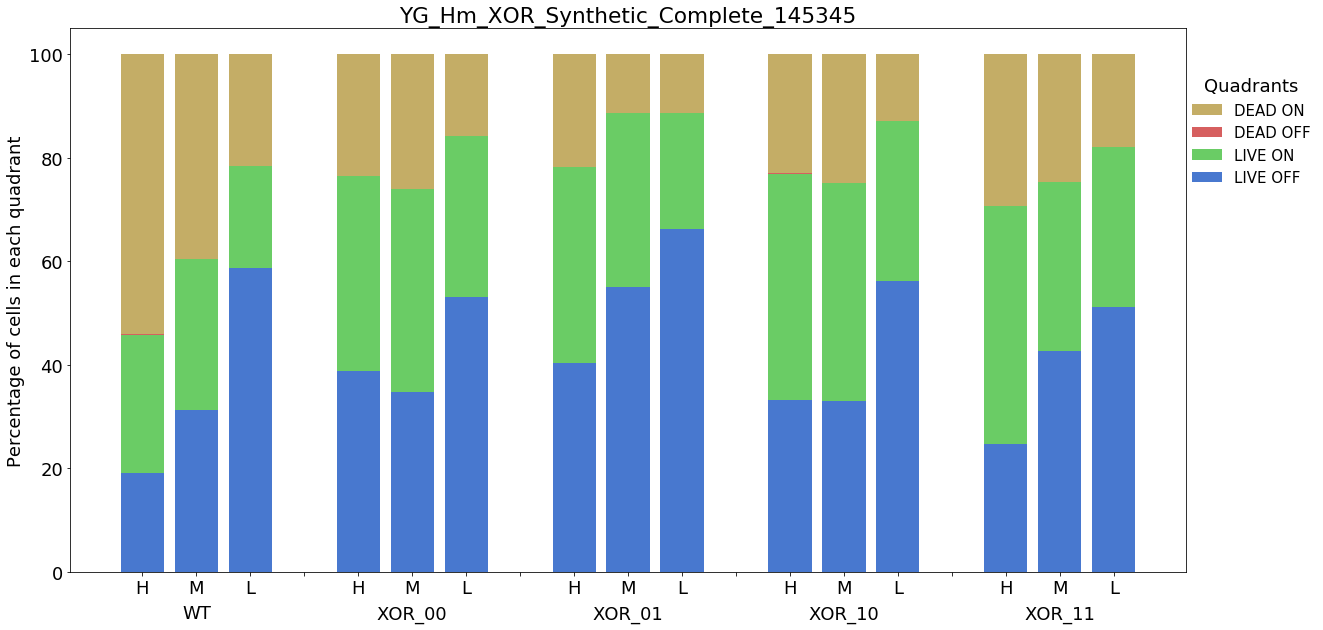

In [40]:
print(save_path)
# Plotting 96 well GFP
plot_plate_gfp(plate, gfp_range, on_threshold, savefig, save_path)

# Plotting 96 well red flourescence channel
plot_plate_sytox(plate, sytox_range, live_threshold, savefig, save_path)

# 2-D Plotting GFP v SYTOX
plot_gfp_sytox(plate, live_off_poly, live_on_poly, dead_off_poly, savefig, save_path)

# percentage_heatmaps(plate, on_off='ON', live_dead='LIVE')

# Applying gates to plate
live_dead_bar_percentage_plots(plate, live_off_poly, live_on_poly, dead_off_poly, savefig, save_path)

### 1M Sorbitol Condition

In [41]:
# Creating ThresholdGates
on_off_cutoff = 5700
on_threshold = ThresholdGate(on_off_cutoff, 'FL1-A', region='above')

live_dead_cutoff = 5150
live_threshold = ThresholdGate(live_dead_cutoff, 'FL4-A', region='below')

gfp_range = (3000, 8000)
gfp_interval = IntervalGate(gfp_range, 'FL1-A', region='in')

sytox_range = (1000, 8000)
sytox_interval = IntervalGate(sytox_range, 'FL4-A', region='in')

vert = [
    (gfp_range[0], sytox_range[0]), 
    (on_off_cutoff, sytox_range[0]), 
    (on_off_cutoff, live_dead_cutoff), 
    (gfp_range[0], live_dead_cutoff)
]

live_off_poly = make_poly_gate(vert, channels=['FL1-A','FL4-A'])
# live_off_poly
vert = [
    (on_off_cutoff, sytox_range[0]), 
    (gfp_range[1], sytox_range[0]), 
    (gfp_range[1], live_dead_cutoff), 
    (on_off_cutoff, live_dead_cutoff)
]

live_on_poly = make_poly_gate(vert)
x1 = 4500
x2 = 7000

vert = [
    (gfp_range[0], live_dead_cutoff), 
    (x1, live_dead_cutoff), 
    (x2, sytox_range[1]), 
    (gfp_range[0], sytox_range[1])
]
dead_off_poly = make_poly_gate(vert)

In [42]:
# Choosing plate with desired condition
media = 'Sorbitol'
plate = ''
for condition in transformed_plate_dict.items():
    if media in condition[0]:
        plate = transformed_plate_dict[condition[0]]
plate = plate.gate(gfp_interval).gate(sytox_interval)
savefig = 'True'
save_path = os.getcwd() + '/plan_{}/{}'.format(plan_id, plate.ID)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


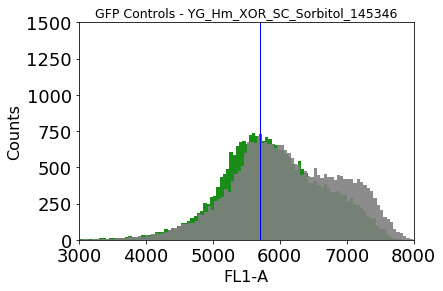

In [43]:
# Plotting gfp positive control
plot_gfp_controls(plate, gfp_range, savefig, save_path, wells_to_plot=['A07', 'A01'])

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


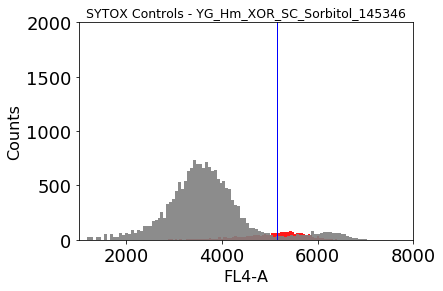

In [44]:
# Plotting SYTOX positive control
plot_sytox_controls(plate, live_threshold, savefig, save_path, wells_to_plot=['H07', 'H08'])

/Users/eribertolopez/Desktop/Aquarium_Programming/trident-master_v2/plan_18598/YG_Hm_XOR_SC_Sorbitol_145346


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


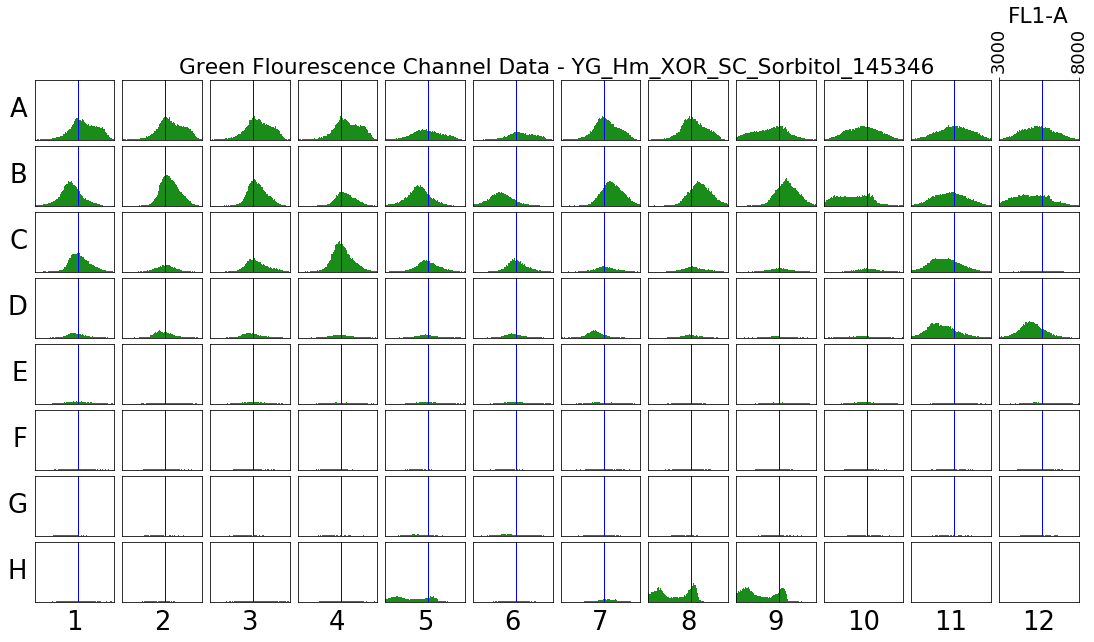

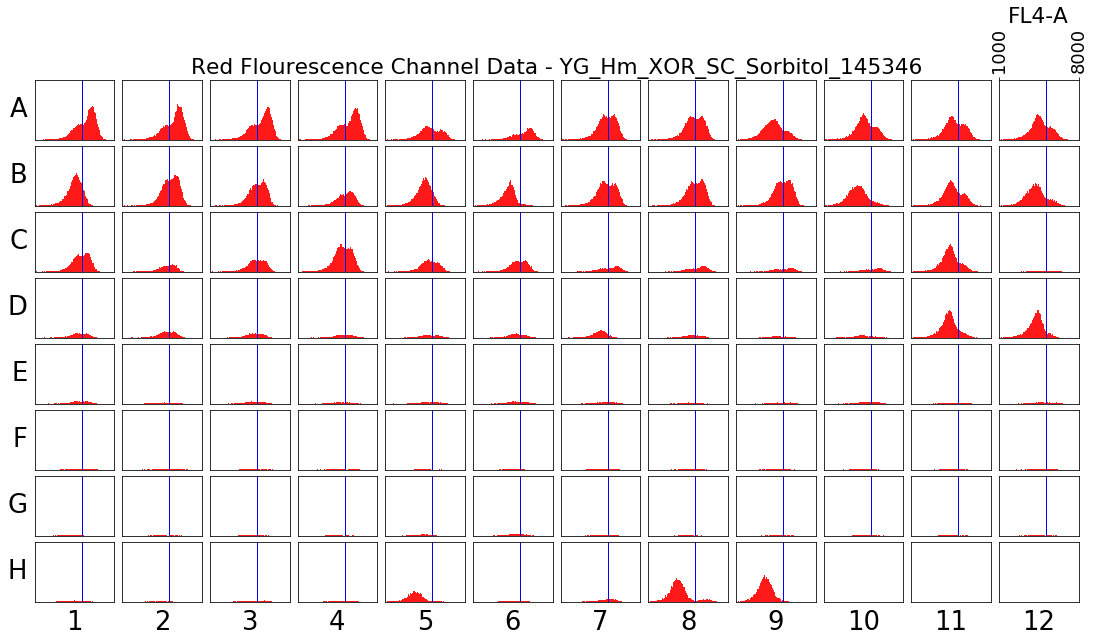

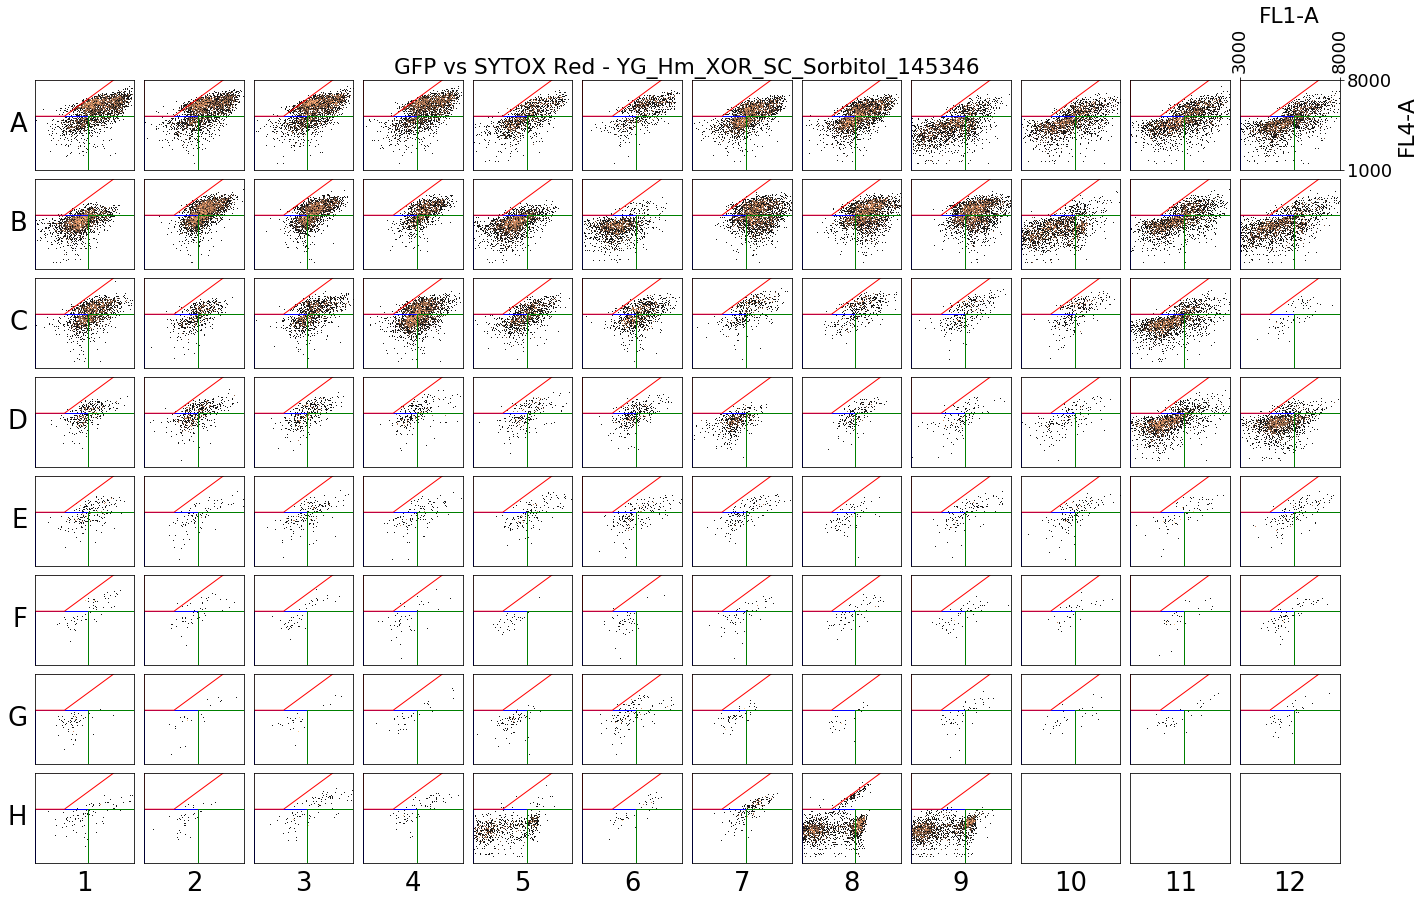

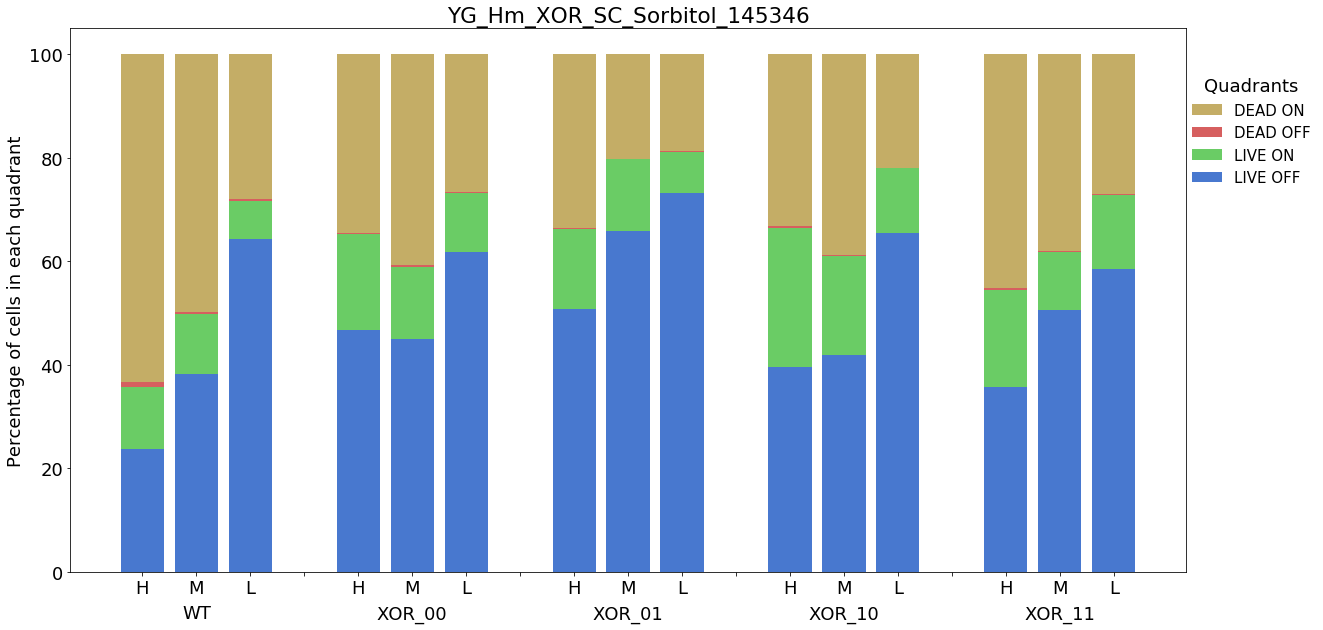

In [45]:
print(save_path)
# Plotting 96 well GFP
plot_plate_gfp(plate, gfp_range, on_threshold, savefig, save_path)

# Plotting 96 well red flourescence channel
plot_plate_sytox(plate, sytox_range, live_threshold, savefig, save_path)

# 2-D Plotting GFP v SYTOX
plot_gfp_sytox(plate, live_off_poly, live_on_poly, dead_off_poly, savefig, save_path)

# percentage_heatmaps(plate, on_off='ON', live_dead='LIVE')

# Applying gates to plate
live_dead_bar_percentage_plots(plate, live_off_poly, live_on_poly, dead_off_poly, savefig, save_path)

### YPAD Condition

In [46]:
# Creating ThresholdGates
on_off_cutoff = 5900
on_threshold = ThresholdGate(on_off_cutoff, 'FL1-A', region='above')

live_dead_cutoff = 5000
live_threshold = ThresholdGate(live_dead_cutoff, 'FL4-A', region='below')

gfp_range = (3000, 8000)
gfp_interval = IntervalGate(gfp_range, 'FL1-A', region='in')

sytox_range = (1000, 8000)
sytox_interval = IntervalGate(sytox_range, 'FL4-A', region='in')

vert = [
    (gfp_range[0], sytox_range[0]), 
    (on_off_cutoff, sytox_range[0]), 
    (on_off_cutoff, live_dead_cutoff), 
    (gfp_range[0], live_dead_cutoff)
]

live_off_poly = make_poly_gate(vert, channels=['FL1-A','FL4-A'])
# live_off_poly
vert = [
    (on_off_cutoff, sytox_range[0]), 
    (gfp_range[1], sytox_range[0]), 
    (gfp_range[1], live_dead_cutoff), 
    (on_off_cutoff, live_dead_cutoff)
]

live_on_poly = make_poly_gate(vert)
x1 = 4500
x2 = 7000

vert = [
    (gfp_range[0], live_dead_cutoff), 
    (x1, live_dead_cutoff), 
    (x2, sytox_range[1]), 
    (gfp_range[0], sytox_range[1])
]
dead_off_poly = make_poly_gate(vert)

In [47]:
# Choosing plate with desired condition
media = 'YPAD'
plate = ''
for condition in transformed_plate_dict.items():
    if media in condition[0]:
        plate = transformed_plate_dict[condition[0]]
plate = plate.gate(gfp_interval).gate(sytox_interval)
savefig = 'True'
save_path = os.getcwd() + '/plan_{}/{}'.format(plan_id, plate.ID)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


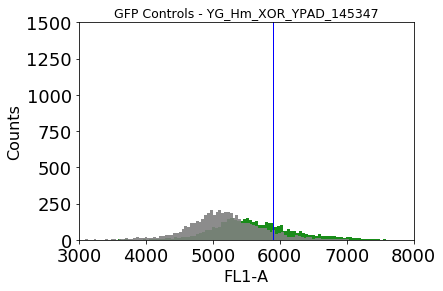

In [48]:
# Plotting gfp positive control
plot_gfp_controls(plate, gfp_range, savefig, save_path, wells_to_plot=['D01', 'D07'])

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


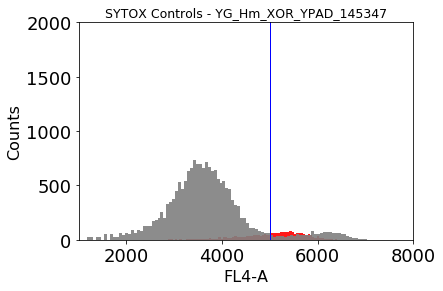

In [49]:
# Plotting SYTOX positive control
plot_sytox_controls(plate, live_threshold, savefig, save_path, wells_to_plot=['H07', 'H08'])

/Users/eribertolopez/Desktop/Aquarium_Programming/trident-master_v2/plan_18598/YG_Hm_XOR_YPAD_145347


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


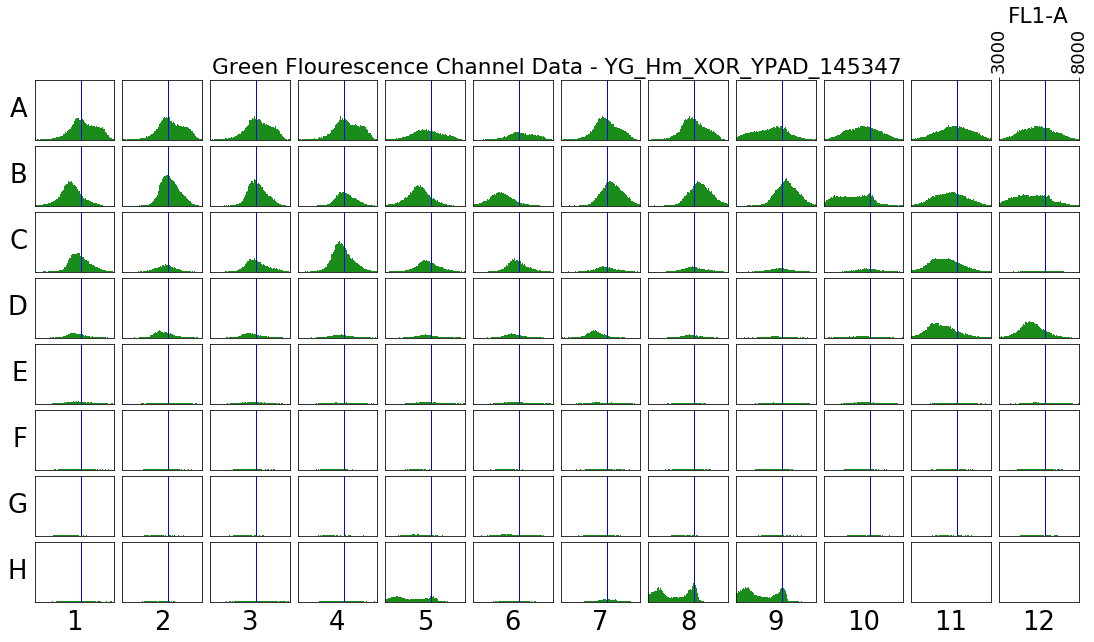

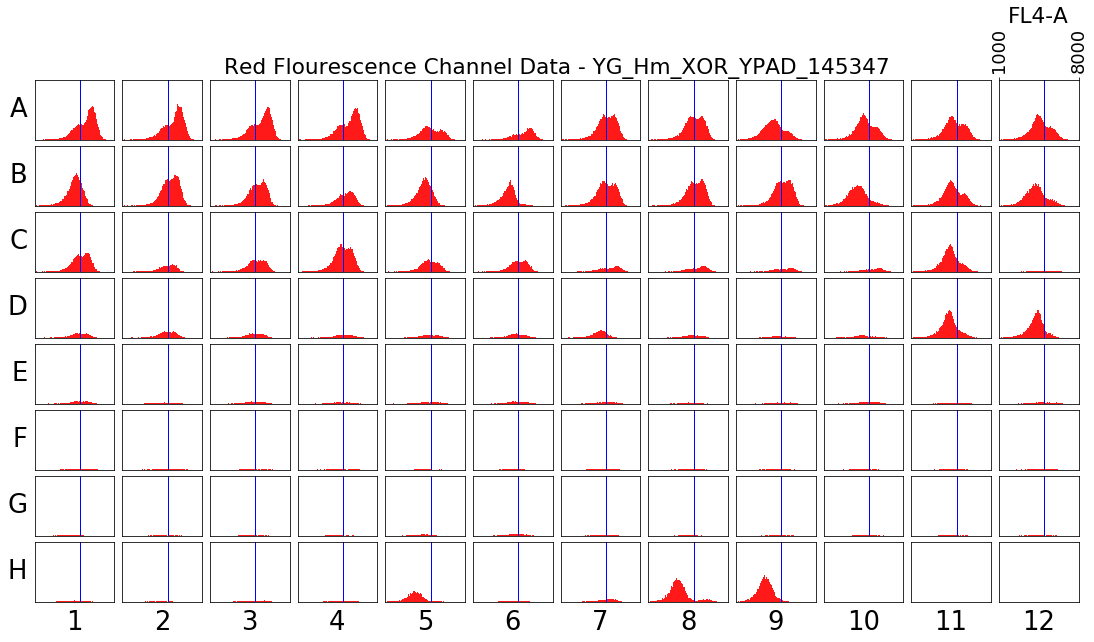

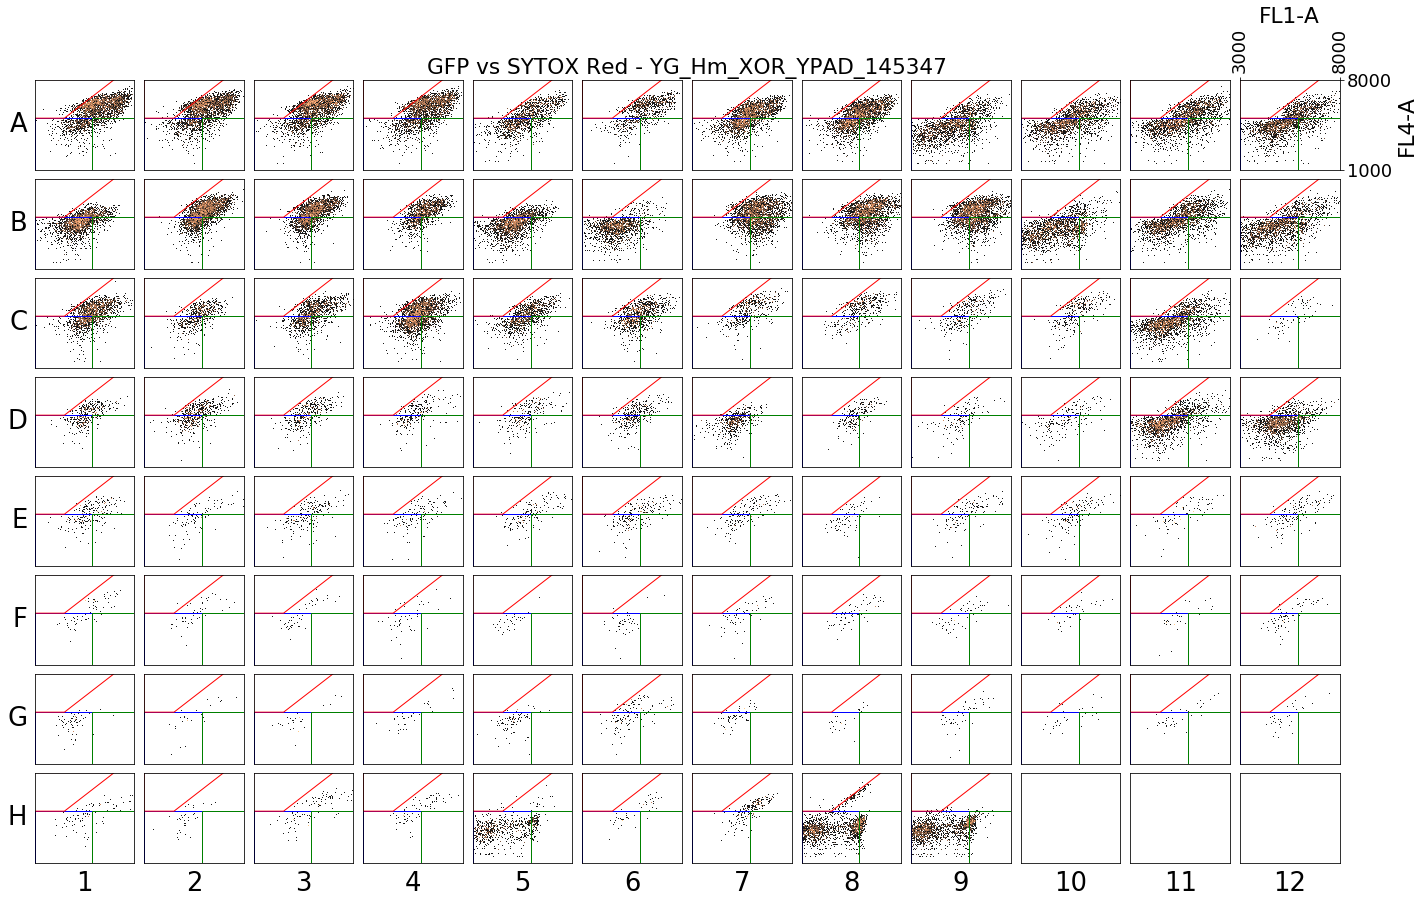

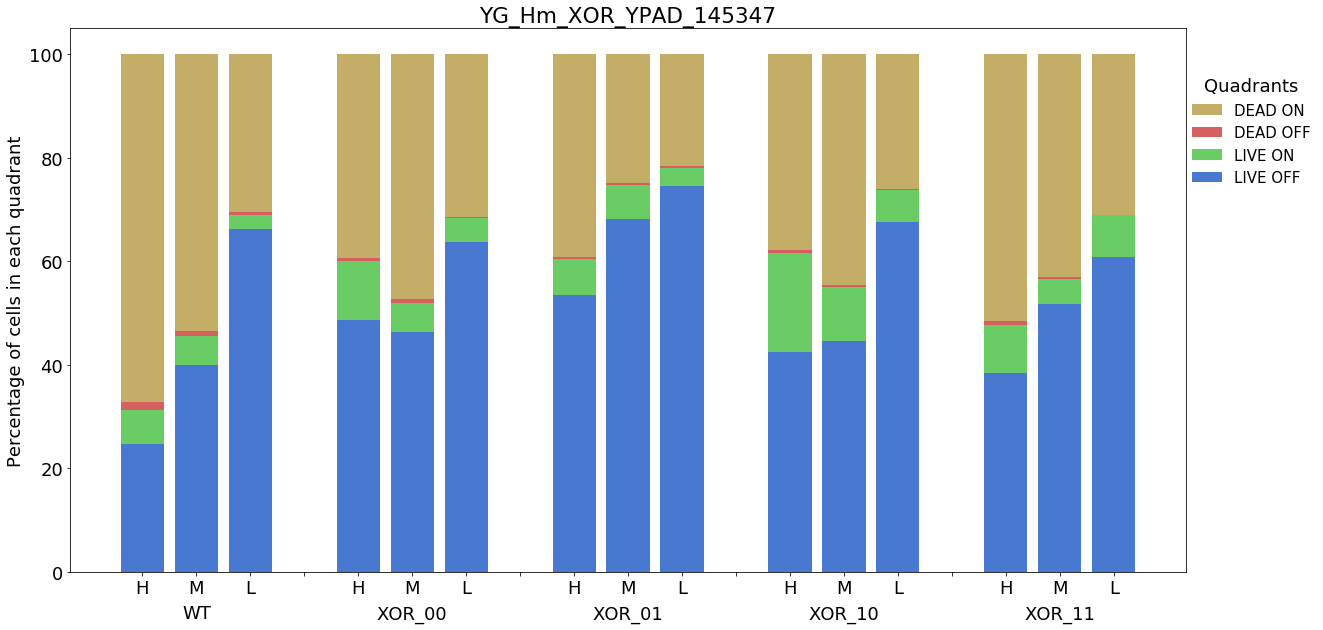

In [50]:
print(save_path)
# Plotting 96 well GFP
plot_plate_gfp(plate, gfp_range, on_threshold, savefig, save_path)

# Plotting 96 well red flourescence channel
plot_plate_sytox(plate, sytox_range, live_threshold, savefig, save_path)

# 2-D Plotting GFP v SYTOX
plot_gfp_sytox(plate, live_off_poly, live_on_poly, dead_off_poly, savefig, save_path)

# percentage_heatmaps(plate, on_off='ON', live_dead='LIVE')

# Applying gates to plate
live_dead_bar_percentage_plots(plate, live_off_poly, live_on_poly, dead_off_poly, savefig, save_path)